# Group Project - Social Media Analysis
## Topic Modeling

Author: Yuwei Zhu

## Table of Content
1. [Data preprocessing](#Data-preprocessing)
    - [Data cleaning](#Data-preprocessing)
    - [NLP data preprocessing(feature extraction)](#Feature-Extraction)
2. [EDA](#EDA)
    - [Time series](#Number-of-post-in-each-day)
    - [Top users](#Top-users)
    - [Correlation](#Correlation)
    - [Word cloud](#World-Cloud)
3. [Topic modeling](#Topic-modeling-using-lemma)
    - [Grid search to determine best LDA models](#Using-grid-search-to-pick-best-lda-model)
    - [Assign posts with dominant topics & sample text](#Dominant-topic-for-each-post)
    - [Word cloud for each topics](#Topic-word-cloud)
4. [Keyword Network Graph](#Create-keywords-network-graph)

In [53]:
# import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
from datetime import datetime
import spacy
import preprocessor as p
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation

import networkx as nx

In [20]:
# load data
df = pd.DataFrame()
path = 'data/'
file_lst = os.listdir(path)
for i in file_lst:
    data = pd.read_excel(os.path.join('data/'+ i),index_col = None)
    df = df.append(data)

In [26]:
df = pd.read_pickle('data_all.pkl')

# Data preprocessing

In [28]:
## Memory Reducer                                     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [29]:
# drop columns with too many NaNs
def drop_nan_column(threshold, df):
    new_df = df.copy()
    total = len(df)
    for column in df:
        percent = df[column].isnull().sum()/total
        if percent > threshold:
            new_df = new_df.drop(columns = [column])
    return new_df

In [30]:
# drop duplicate rows
df = df.drop_duplicates()

In [31]:
len(df)

511269

In [38]:
# drop rows with empty text
df.drop(df[df['Sound Bite Text'].isnull()].index, inplace = True)

In [39]:
len(df)

327228

In [27]:
# check df columns types
for col in df.columns:
    print('{0:15s} data type is: {1:10s}'.format(str(col), str(df[col].dtype)))

Post ID         data type is: object    
Sound Bite Text data type is: object    
Ratings and Scores data type is: float64   
Title           data type is: object    
Source Type     data type is: object    
Post Type       data type is: object    
Media Type      data type is: object    
URL             data type is: object    
Domain          data type is: object    
Published Date (GMT-04:00) New York data type is: object    
Author Gender   data type is: object    
Author URL      data type is: object    
Author Name     data type is: object    
Author Handle   data type is: object    
Author ID       data type is: object    
Author Location - Country 1 data type is: object    
Author Location - State/Province 1 data type is: object    
Author Location - City 1 data type is: object    
Author Location - Country 2 data type is: object    
Author Location - State/Province 2 data type is: object    
Author Location - City 2 data type is: object    
Author Location - Other data type is

In [40]:
# convert date column to type datetime
df['Published Date (GMT-04:00) New York'] = pd.to_datetime(df['Published Date (GMT-04:00) New York'])

In [41]:
# drop rows with review text deleted
df.drop(df[(df["Sound Bite Text"] == "Post deleted by the author.")].index, inplace = True)

In [30]:
df.shape

(327231, 41)

In [35]:
# reduce memory
df = reduce_mem_usage(df)

Mem. usage decreased to 93.62 Mb (10.7% reduction)


In [14]:
df.head(3).transpose()

0  \
Post ID                                 http://www.cnet.com/news/harrison-ford-drinks-...   
Sound Bite Text                         So out came the Bruichladdich , a fine scotch ...   
Ratings and Scores                                                                    NaN   
Title                                   Harrison Ford drinks scotch, tells jokes with ...   
Source Type                                                                         Blogs   
Post Type                                                                        Original   
Media Type                                                                       No Media   
URL                                     http://www.cnet.com/news/harrison-ford-drinks-...   
Domain                                                                           cnet.com   
Published Date (GMT-04:00) New York                                   2017-09-29 05:06:00   
Author Gender                                                                     Unknown   
Author URL                                                                            NaN   
Author Name                                                                           NaN   
Author Handle                                                                         NaN   
Author ID                                                                             NaN   
Author Location - Country 1                                                 United States   
Author Location - State/Province 1                                                    NaN   
Author Location - City 1                                                              NaN   
Author Location - Country 2                                                           NaN   
Author Location - State/Province 2                                                    NaN   
Author Location - City 2                                                              NaN   
Author Location - Other                                                               NaN   
No. of Followers/Daily Unique Visitors                                                  0   
Professions                                                                           NaN   
Interests                                                                             NaN   
Positive Objects                                                                      NaN   
Negative Objects                                                                      NaN   
Richness                                                                                1   
Tags                                                                                  NaN   
Quoted Post                                                                           NaN   
Quoted Author Name                                                                    NaN   
Quoted Author Handle                                                                  NaN   
Total Engagements                                                                     NaN   
Post Comments                                                                         NaN   
Post Likes                                                                            NaN   
Post Shares                                                                           NaN   
Post Views                                                                            NaN   
Post Dislikes                                                                         NaN   
Product Name                                                                          NaN   
Product Hierarchy                                                                     NaN   
Rating                                                                                NaN   

                                                                                        1  \
Post ID                                                              1824442430021468289

In [15]:
df.describe()

Ratings and Scores  No. of Followers/Daily Unique Visitors  Richness  \
count                 0.0                            3.272290e+05  327229.0   
mean                  NaN                            5.489109e+04       NaN   
std                   NaN                            1.487094e+06       0.0   
min                   NaN                            0.000000e+00       0.0   
25%                   NaN                            0.000000e+00       1.0   
50%                   NaN                            0.000000e+00       1.0   
75%                   NaN                            0.000000e+00       2.0   
max                   NaN                            1.277749e+08      12.0   

       Tags  Total Engagements  Post Comments     Post Likes  Post Shares  \
count   0.0       33208.000000        19385.0   31796.000000        709.0   
mean    NaN         364.938385            inf     368.631378          inf   
std     NaN        2485.772461            inf    2450.351318          inf   
min     NaN           1.000000            1.0       1.000000          1.0   
25%     NaN           9.000000            1.0      10.000000          4.0   
50%     NaN          28.000000            3.0      28.500000         12.0   
75%     NaN          78.000000            6.0      79.000000         43.0   
max     NaN      172094.000000        11224.0  158629.000000      12728.0   

       Post Views  Post Dislikes  Product Hierarchy       Rating  
count         0.0            0.0                0.0  1386.000000  
mean          NaN            NaN                NaN     3.607422  
std           NaN            NaN                NaN     1.420898  
min           NaN            NaN                NaN     0.000000  
25%           NaN            NaN                NaN     3.000000  
50%           NaN            NaN                NaN     4.000000  
75%           NaN            NaN                NaN     5.000000  
max           NaN            NaN                NaN     5.000000

## Feature Extraction

In [33]:
# drop replies and comments, only keep the original post
nlp_data = df.loc[df['Post Type'] == 'Original'].reset_index()[['Sound Bite Text','date_day']]

In [62]:
nlp_data.drop(nlp_data[nlp_data['date_day'].isnull()].index, inplace = True)

In [34]:
nlp_data['original_text'] = df.loc[df['Post Type'] == 'Original'].reset_index()[['Sound Bite Text']]

In [48]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'], max_length = 1000000000)

In [46]:
nlp = en_core_web_sm.load(disable = ['ner', 'parser'], max_length = 1000000000)

In [42]:
import en_core_web_sm

In [47]:
nlp_data = nlp_data.fillna('')

In [48]:
def clean_data(df):
    text = df
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
   
    return text

In [49]:
nlp_data['Sound Bite Text'] = nlp_data['Sound Bite Text'].apply(clean_data)

In [50]:
# remove url, hastag, etc.
# using twitter preprocessor package
nlp_data['Sound Bite Text'] = nlp_data['Sound Bite Text'].apply(lambda x: p.clean(x))

AttributeError: module 'preprocessor' has no attribute 'clean'

In [55]:
# tokenize
nlp_data['clean_text'] = nlp_data['Sound Bite Text'].apply(lambda x: nlp.tokenizer(x))

In [11]:
# split product
def conditions(df):
    if ('iphone' in df['Sound Bite Text']) and ('galaxy' in df['Sound Bite Text']):
        product = 'both'
        return product
    if ('iphone' in df['Sound Bite Text']):
        product = 'iPhone'
        return product
    if ('galaxy' in df['Sound Bite Text']):
        product = 'Galaxy'
        return product
    else:
        product = 'not known'
        return product

In [12]:
nlp_data['product'] = nlp_data.apply(conditions, axis = 1)

In [14]:
nlp_data.groupby('product').count()

Sound Bite Text  clean_text   lemma   clean  original_text
product                                                              
Galaxy              124233      124233  124233  124233         124233
both                 28164       28164   28164   28164          28164
iPhone              118148      118148  118148  118148         118148
not known                4           4       4       4              4

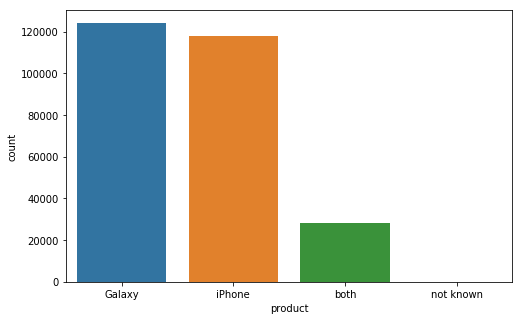

In [13]:
plt.figure(figsize = (8,5))
sns.countplot(nlp_data['product'], order = nlp_data['product'].value_counts().index)
plt.show()

In [82]:
def launch(df):
    if df['product'] == 'iPhone':
        if df['date_day'] > datetime.strptime('2017-09-22', '%Y-%m-%d').date():
            release = 'after'
            return release
        else:
            release = 'before'
            return release
    if df['product'] == 'Galaxy':
        if df['date_day'] > datetime.strptime('2017-03-29', '%Y-%m-%d').date():
            release = 'after'
            return release
        else:
            release = 'before'
            return release
    else:
        if df['date_day'] < datetime.strptime('2017-03-29', '%Y-%m-%d').date():
            release = 'before'
            return release
        if df['date_day'] < datetime.strptime('2017-06-06', '%Y-%m-%d').date():
            release = 'after'
            return release
        if df['date_day'] < datetime.strptime('2017-09-22', '%Y-%m-%d').date():
            release = 'before'
            return release
        else:
            release = 'after'
            return release

In [83]:
nlp_data['release'] = nlp_data.apply(launch, axis = 1)

In [85]:
nlp_data.groupby('release').count()

Sound Bite Text  clean_text  product   lemma   clean  original_text  \
release                                                                        
after             182430      182430   182430  182430  182430         182430   
before             88118       88118    88118   88118   88118          88118   

         date_day  
release            
after      182430  
before      88118

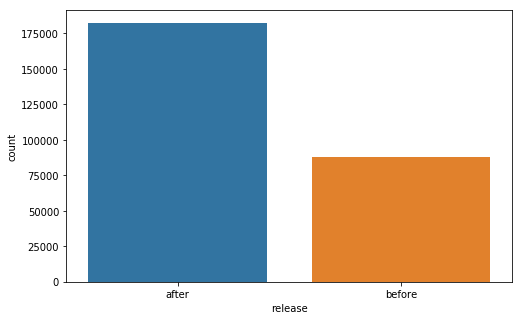

In [84]:
plt.figure(figsize = (8,5))
sns.countplot(nlp_data['release'], order = nlp_data['release'].value_counts().index)
plt.show()

In [231]:
nlp_data.groupby(['release','product']).count()

Sound Bite Text  clean_text   lemma   clean  original_text  \
release product                                                                 
after   Galaxy              103260      103260  103260  103260         103260   
        both                 23272       23272   23272   23272          23272   
        iPhone               55894       55894   55894   55894          55894   
        not known                4           4       4       4              4   
before  Galaxy               20972       20972   20972   20972          20972   
        both                  4892        4892    4892    4892           4892   
        iPhone               62254       62254   62254   62254          62254   

                   date_day  
release product              
after   Galaxy       103260  
        both          23272  
        iPhone        55894  
        not known         4  
before  Galaxy        20972  
        both           4892  
        iPhone        62254

In [59]:
# lemma
def lemma(df):
    lemma_text = []
    for i in df['clean_text']:
        lemma_text.append(i.lemma_)
    return lemma_text

In [60]:
nlp_data['lemma'] = nlp_data.apply(lemma, axis = 1)

In [61]:
# remove stopwords
def stopwords(df):
    filtered_sentence = []
    for word in df['lemma']:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return filtered_sentence

In [62]:
nlp_data['clean'] = nlp_data.apply(stopwords, axis = 1)

In [66]:
nlp_data.to_pickle('data_clean.pkl')

KeyboardInterrupt: 

In [9]:
nlp_data = pd.read_pickle('data_clean.pkl')

# EDA

## Post Profile 
### Number of post in each day

In [42]:
# date
df['date_day'] = df['Published Date (GMT-04:00) New York'].dt.date

/Users/zhuyuwei/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


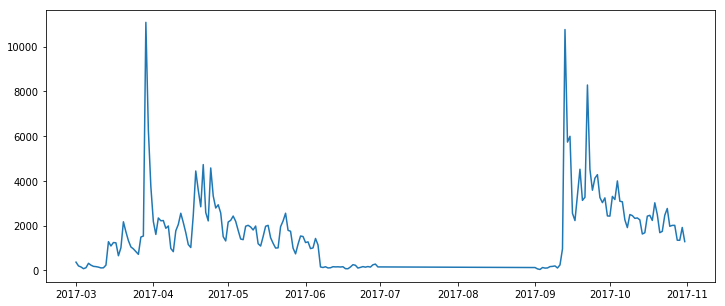

In [12]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(df.groupby(['date_day'])['Post ID'].count())

The peak number of post for both product were close. However, iPhone 8 and X had an additional posting peak within 10 days. Also, the following discussion about iPhone on social media looks more intenvise than Samsung Galaxy S8.

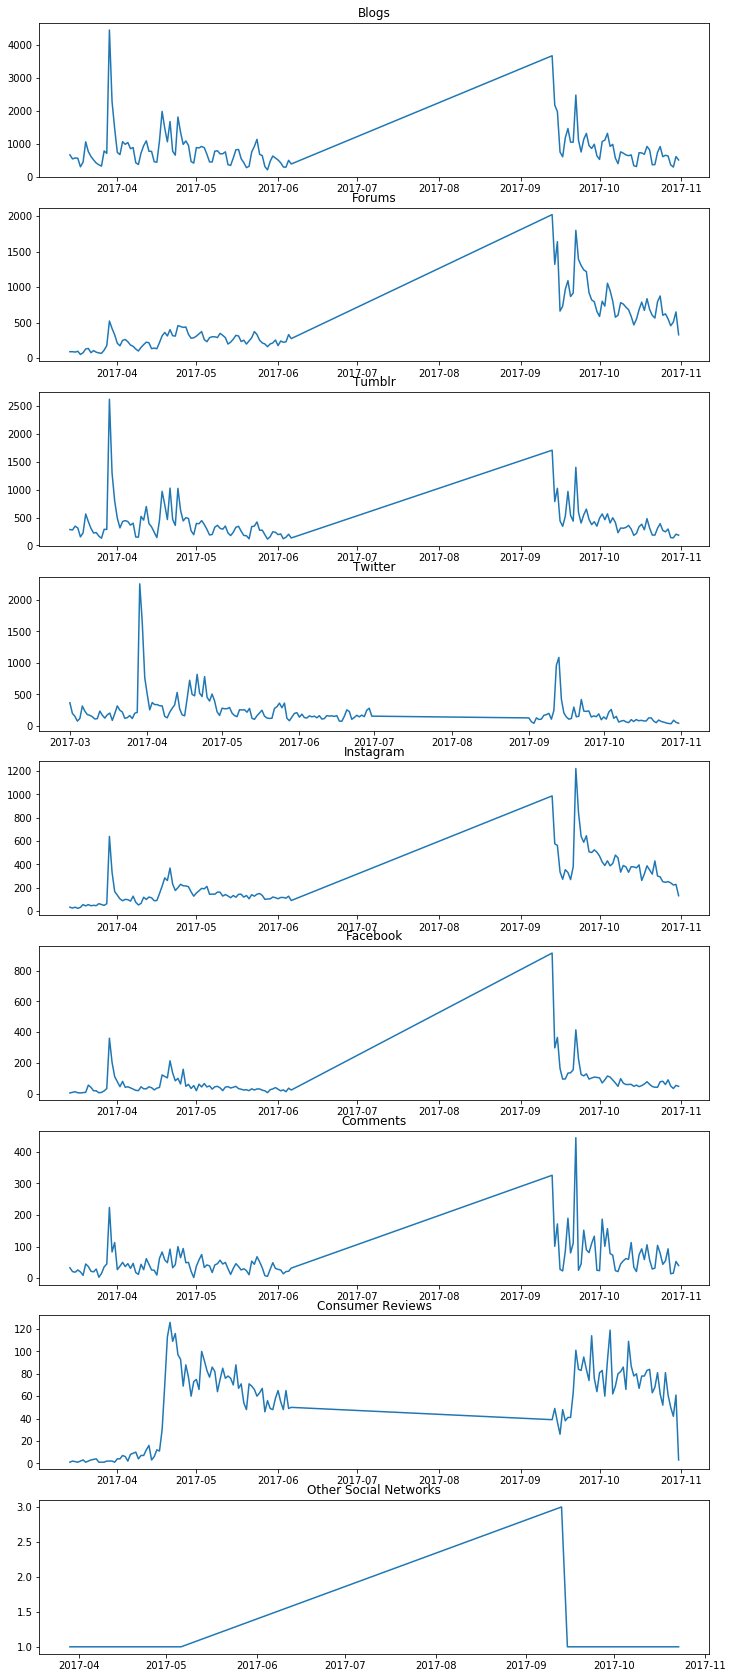

In [14]:
# seperate by source
plt.rcParams["figure.figsize"] = (12,30)
sources = df['Source Type'].value_counts()
for i in range(1,10):
    plt.subplot(9,1,i)
    source_data = df.loc[df['Source Type'] == str(sources.index[i-1])]
    plt.title(str(sources.index[i-1]))
    plt.plot(source_data.groupby(['date_day'])['Post ID'].count())

User posts and comments on different sources are not totally simultaneously. When Samsung Galaxy S8 released, twitter and consumer reviews response later than other social media. However, when iPhone 8 and iPhone X released, all the other sources excepts consumer reviews response in relatively same time.

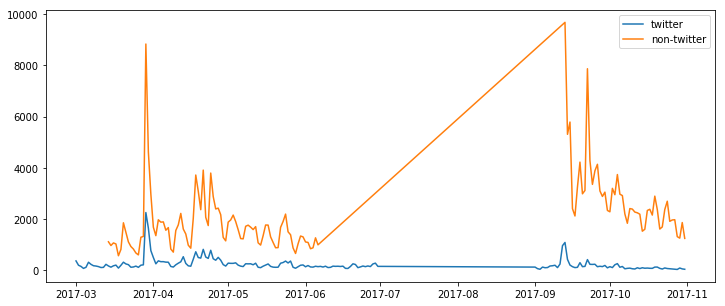

In [15]:
# twitter vs. non-twitter
plt.rcParams["figure.figsize"] = (12,5)
twitter = df.loc[df['Source Type'] == 'Twitter']
non_twitter = df.loc[df['Source Type'] != 'Twitter']
labels = ['twitter', 'non-twitter']

plt.plot(twitter.groupby(['date_day'])['Post ID'].count())
plt.plot(non_twitter.groupby(['date_day'])['Post ID'].count())
plt.legend(labels)

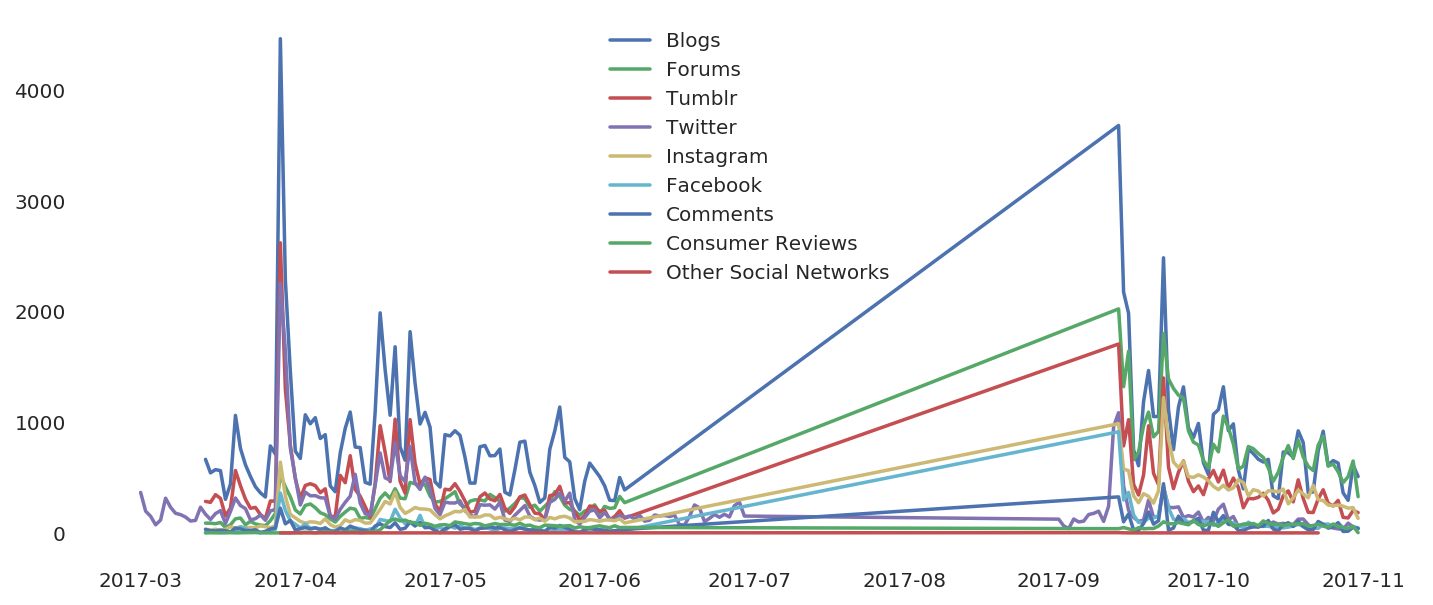

In [349]:
sources = df['Source Type'].value_counts()
plt.rcParams["figure.figsize"] = (12,5)
#plt.rcParams['axes.facecolor']='white'
for i in range(1,10):
    source_data = df.loc[df['Source Type'] == str(sources.index[i-1])]
    plt.plot(source_data.groupby(['date_day'])['Post ID'].count())
plt.legend(sources.index.tolist())

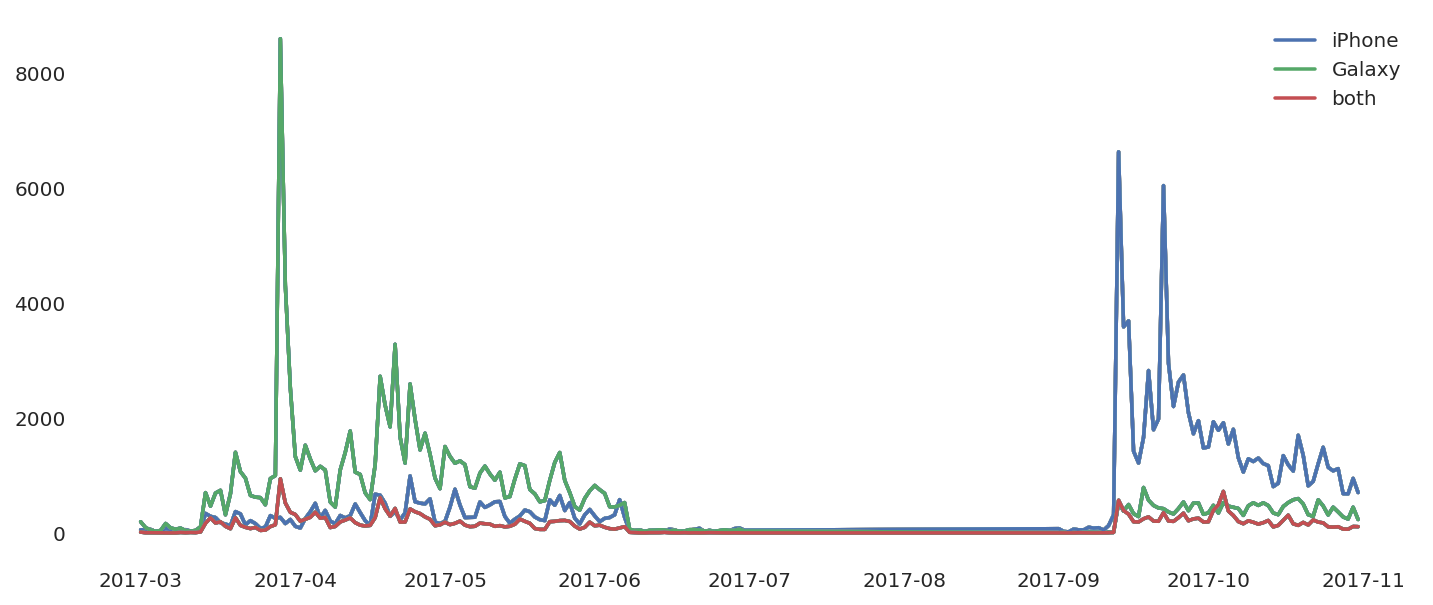

In [350]:
# twitter vs. non-twitter
plt.rcParams["figure.figsize"] = (12,5)
#plt.rcParams['axes.facecolor']='white'
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']
both = nlp_data.loc[nlp_data['product'] == 'both']
labels = ['iPhone','Galaxy','both']

plt.plot(iphone.groupby(['date_day']).count())
plt.plot(galaxy.groupby(['date_day']).count())
plt.plot(both.groupby(['date_day']).count())

plt.legend(labels)

When samsung Galaxy S8 released, twitter and non-twitter responses similar. However, users on twitter response were not so overwhelming comparing to other sources.

## Top users

In [16]:
followers = df.groupby('Post ID').agg({'No. of Followers/Daily Unique Visitors': 'max'})
followers = followers.loc[followers['No. of Followers/Daily Unique Visitors'] > 10]
count = followers['No. of Followers/Daily Unique Visitors'].value_counts().tolist()
follower_number = followers['No. of Followers/Daily Unique Visitors'].value_counts().index.tolist()

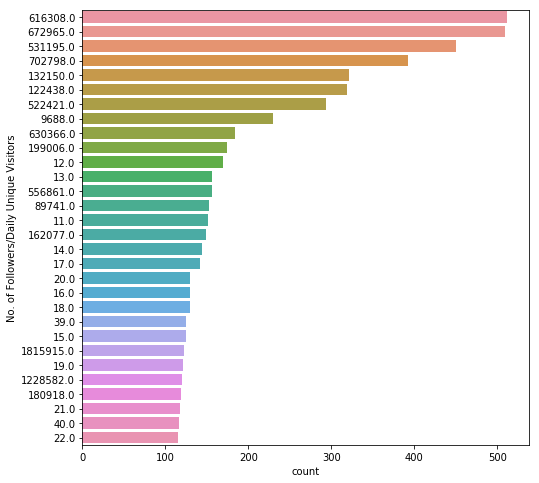

In [17]:
plt.figure(figsize = (8,8))
sns.countplot(y = followers["No. of Followers/Daily Unique Visitors"], \
              order = followers["No. of Followers/Daily Unique Visitors"].value_counts().index[:30])
plt.show()

In [18]:
# top 10 user
followers.reset_index().sort_values(by = 'No. of Followers/Daily Unique Visitors', ascending = False).head(10)

Post ID  \
116                   104753296264554_1477511468988723   
117                   104753296264554_1478921125514424   
176  107593572595009_1453195688034784_1466950189992667   
779   133803174373_10155328236859374_10155335472539374   
197  107593572595009_1514091941945158_1515324875155198   
198  107593572595009_1514091941945158_1515344831819869   
199  107593572595009_1514091941945158_1515347155152970   
200                   107593572595009_1518759574811728   
201                   107593572595009_1674975705856780   
774   133803174373_10155322839224374_10155335472344374   

     No. of Followers/Daily Unique Visitors  
116                             127774880.0  
117                             127774880.0  
176                             116854496.0  
779                             116854496.0  
197                             116854496.0  
198                             116854496.0  
199                             116854496.0  
200                             116854496.0  
201                             116854496.0  
774                             116854496.0

## Correlation

In [23]:
# drop nan columns
drop_nan = drop_nan_column(0.95, df)

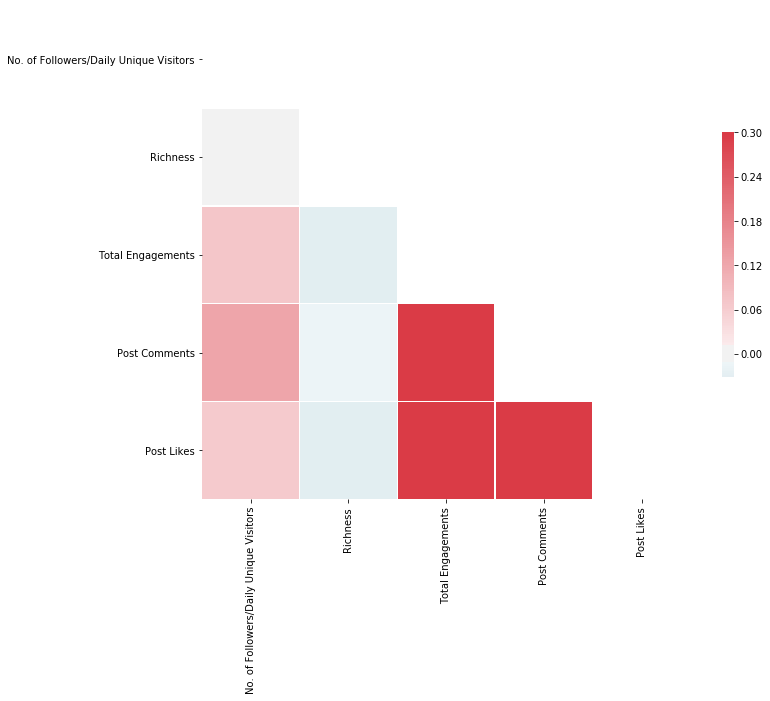

In [24]:
correlation_matrix = drop_nan.corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Word Cloud

In [69]:
iphone_original = nlp_data.loc[nlp_data['product'] == 'iPhone']['original_text'].tolist()
galaxy_original = nlp_data.loc[nlp_data['product'] == 'Galaxy']['original_text'].tolist()
both_original = nlp_data.loc[nlp_data['product'] == 'both']['original_text'].tolist()

In [167]:
iphone_before_orignal = nlp_data.loc[(nlp_data['product'] == 'iPhone') & (nlp_data['release'] == 'before')]['original_text'].tolist()
iphone_after_orignal = nlp_data.loc[(nlp_data['product'] == 'iPhone') & (nlp_data['release'] == 'after')]['original_text'].tolist()

galaxy_before_orignal = nlp_data.loc[(nlp_data['product'] == 'Galaxy') & (nlp_data['release'] == 'before')]['original_text'].tolist()
galaxy_after_orignal = nlp_data.loc[(nlp_data['product'] == 'Galaxy') & (nlp_data['release'] == 'after')]['original_text'].tolist()

both_before_orignal = nlp_data.loc[(nlp_data['product'] == 'both') & (nlp_data['release'] == 'before')]['original_text'].tolist()
both_after_orignal = nlp_data.loc[(nlp_data['product'] == 'both') & (nlp_data['release'] == 'after')]['original_text'].tolist()

In [70]:
# create bag of words
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']['clean'].tolist()
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']['clean'].tolist()
both = nlp_data.loc[nlp_data['product'] == 'both']['clean'].tolist()

In [71]:
iphone = [word for sublist in iphone for word in sublist]

In [72]:
galaxy = [word for sublist in galaxy for word in sublist]

In [73]:
both = [word for sublist in both for word in sublist]

In [74]:
iphone = " ".join(iphone)
galaxy = " ".join(galaxy)
both = " ".join(both)

In [106]:
iphone_before = nlp_data.loc[(nlp_data['product'] == 'iPhone') & (nlp_data['release'] == 'before')]['clean'].tolist()
iphone_after = nlp_data.loc[(nlp_data['product'] == 'iPhone') & (nlp_data['release'] == 'after')]['clean'].tolist()

galaxy_before = nlp_data.loc[(nlp_data['product'] == 'Galaxy') & (nlp_data['release'] == 'before')]['clean'].tolist()
galaxy_after = nlp_data.loc[(nlp_data['product'] == 'Galaxy') & (nlp_data['release'] == 'after')]['clean'].tolist()

both_before = nlp_data.loc[(nlp_data['product'] == 'both') & (nlp_data['release'] == 'before')]['clean'].tolist()
both_after = nlp_data.loc[(nlp_data['product'] == 'both') & (nlp_data['release'] == 'after')]['clean'].tolist()

In [107]:
iphone_before = [word for sublist in iphone_before for word in sublist]
iphone_after = [word for sublist in iphone_after for word in sublist]
iphone_before = " ".join(iphone_before)
iphone_after = " ".join(iphone_after)

In [108]:
galaxy_before = [word for sublist in galaxy_before for word in sublist]
galaxy_after = [word for sublist in galaxy_after for word in sublist]
galaxy_before = " ".join(galaxy_before)
galaxy_after = " ".join(galaxy_after)

In [109]:
both_before = [word for sublist in both_before for word in sublist]
both_after = [word for sublist in both_after for word in sublist]
both_before = " ".join(both_before)
both_after = " ".join(both_after)

In [75]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [318]:
iphone_stopwords = spacy_stopwords
# iphone_stopwords.add('iphone')
# iphone_stopwords.add('samsung')
iphone_stopwords.add('PRON')
# iphone_stopwords.add('apple')
iphone_stopwords.add('plus')
iphone_stopwords.add('phone')
iphone_stopwords.add('8')
iphone_stopwords.add('x')
iphone_stopwords.add('s')
iphone_stopwords.add('t')
iphone_stopwords.add('ift')
iphone_stopwords.add('tt')
iphone_stopwords.add('http')
iphone_stopwords.add('gb')
iphone_stopwords.add('com')
iphone_stopwords.add('twitter')

In [319]:
both_stopwords = spacy_stopwords
# both_stopwords.add('iphone')
# both_stopwords.add('samsung')
both_stopwords.add('PRON')
both_stopwords.add('apple')
both_stopwords.add('plus')
both_stopwords.add('phone')
both_stopwords.add('8')
both_stopwords.add('x')
both_stopwords.add('s')
both_stopwords.add('t')
both_stopwords.add('ift')
both_stopwords.add('tt')
both_stopwords.add('http')
both_stopwords.add('gb')
both_stopwords.add('com')
both_stopwords.add('twitter')

In [320]:
galaxy_stopwords = spacy_stopwords
# galaxy_stopwords.add('galaxy')
# galaxy_stopwords.add('samsung')
galaxy_stopwords.add('smartphone')
galaxy_stopwords.add('s7')
galaxy_stopwords.add('s8')
galaxy_stopwords.add('lg')
galaxy_stopwords.add('g6')
galaxy_stopwords.add('ift')
galaxy_stopwords.add('tt')
galaxy_stopwords.add('http')
galaxy_stopwords.add('https')
galaxy_stopwords.add('gb')
galaxy_stopwords.add('com')
galaxy_stopwords.add('twitter')

In [72]:
nlp_data.head()

Sound Bite Text  \
0  trump makes everyone nervous case mate tough e...   
1  this galaxy s takes great night pictures japan...   
2  loup ventures gene munster apple s shed billio...   
3  samsung galaxy s is a mobile which comes with ...   
4  apple has unveiled the iphone x pronounced iph...   

                                       original_text  \
0  Trump makes everyone nervous Case-Mate tough e...   
1  This galaxy s8 takes great night pictures. #ja...   
2  Loup Ventures의 Gene Munster, 아이폰 신제품 발표후 5-10%...   
3  Samsung Galaxy S8+ is a mobile which comes wit...   
4  Apple has unveiled the iPhone X – pronounced i...   

                                          clean_text product  \
0  (trump, makes, everyone, nervous, case, mate, ...  iPhone   
1  (this, galaxy, s, takes, great, night, picture...  Galaxy   
2  (loup, ventures, gene, munster, apple, s, shed...  iPhone   
3  (samsung, galaxy, s, is, a, mobile, which, com...  Galaxy   
4  (apple, has, unveiled, the, iphone, x, pronoun...  iPhone   

                                               lemma  \
0  [trump, make, everyone, nervous, case, mate, t...   
1  [this, galaxy, s, take, great, night, picture,...   
2  [loup, venture, gene, munster, apple, s, shed,...   
3  [samsung, galaxy, s, be, a, mobile, which, com...   
4  [apple, have, unveil, the, iphone, x, pronounc...   

                                               clean  
0  [trump, nervous, case, mate, tough, extreme, i...  
1  [galaxy, s, great, night, picture, japantown, ...  
2  [loup, venture, gene, munster, apple, s, shed,...  
3  [samsung, galaxy, s, mobile, come, inch, displ...  
4  [apple, unveil, iphone, x, pronounce, iphone, ...

In [110]:
import gc
gc.collect()

18832

### Both

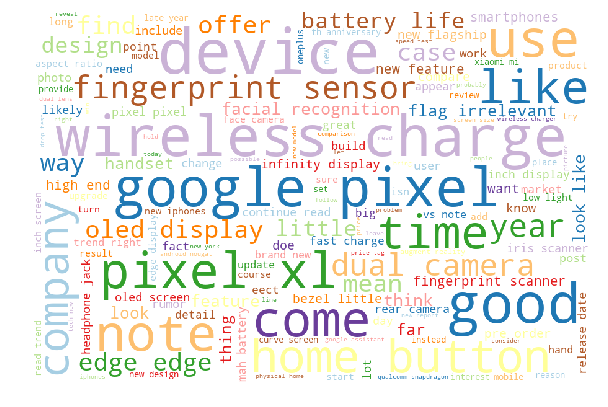

In [89]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=both_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(both)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("both_word1.png", dpi=1000)

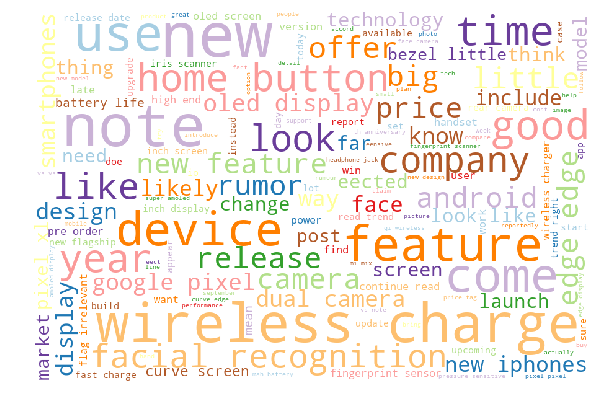

In [112]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=both_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(both_before)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("both_before_word1.png", dpi=1000)

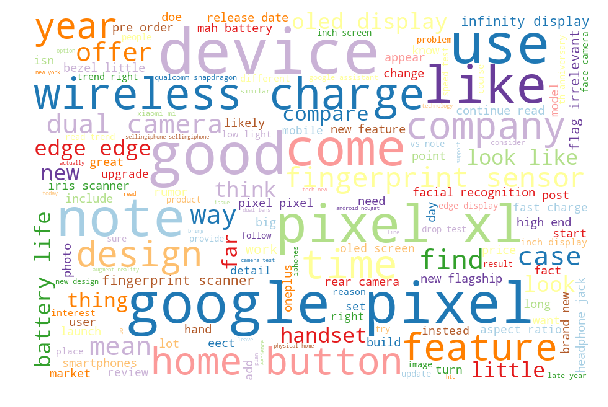

In [113]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=both_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(both_after)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("both_after_word1.png", dpi=1000)

### iPhone

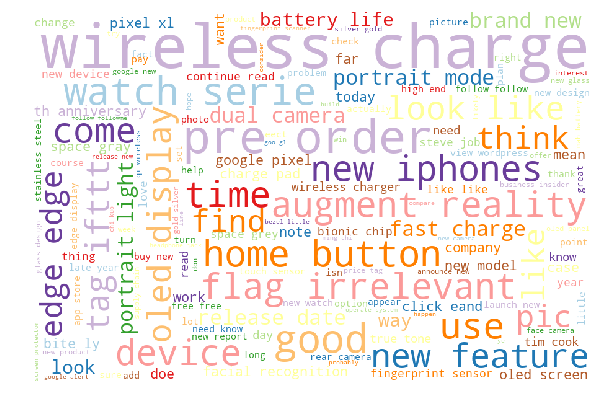

In [114]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(iphone)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("iphone_word1.png", dpi=1000)

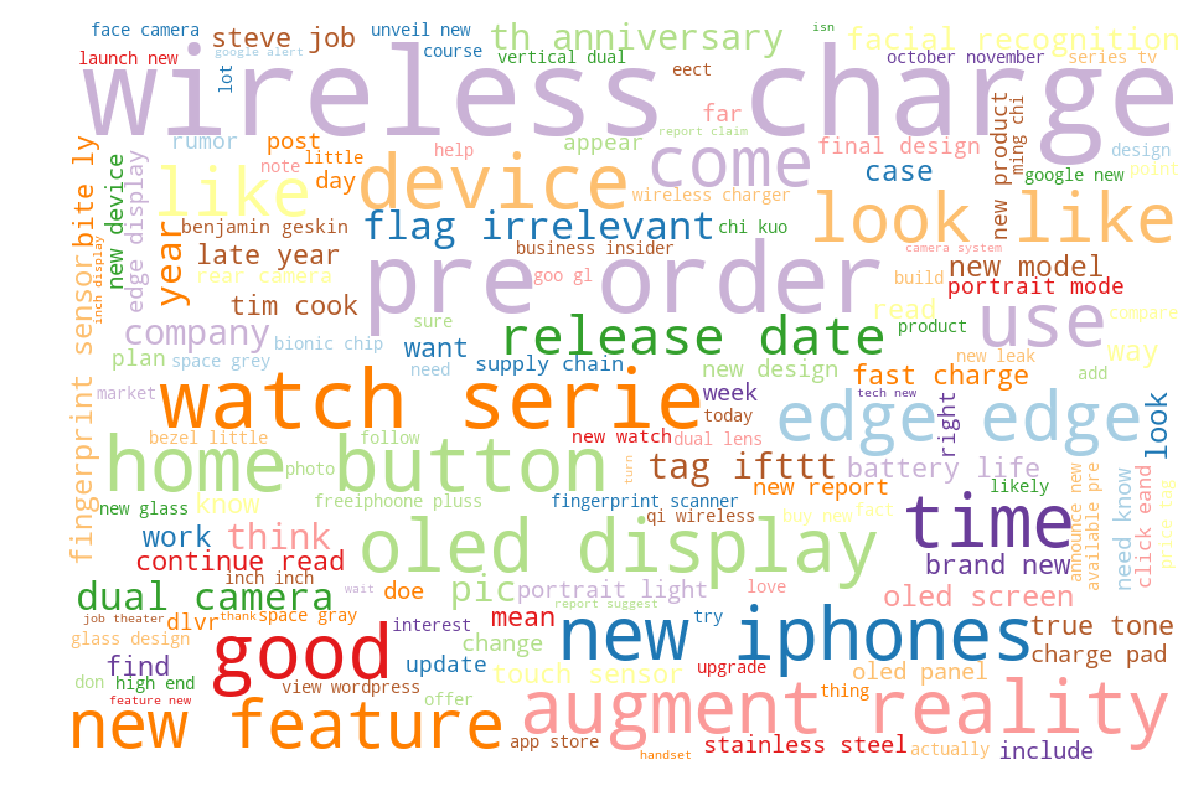

In [321]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(iphone_before)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("iphone_before_word1.png", dpi=1000)

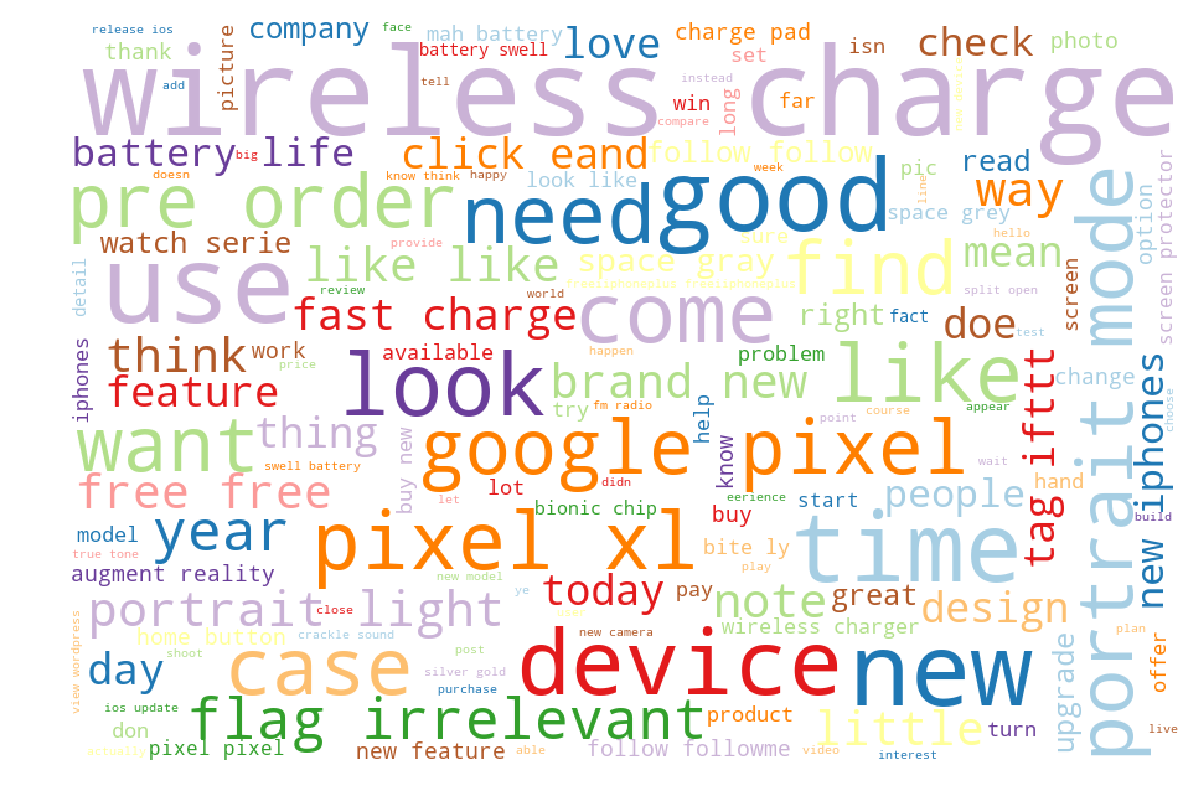

In [322]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(iphone_after)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("iphone_after_word1.png", dpi=1000)

### Galaxy

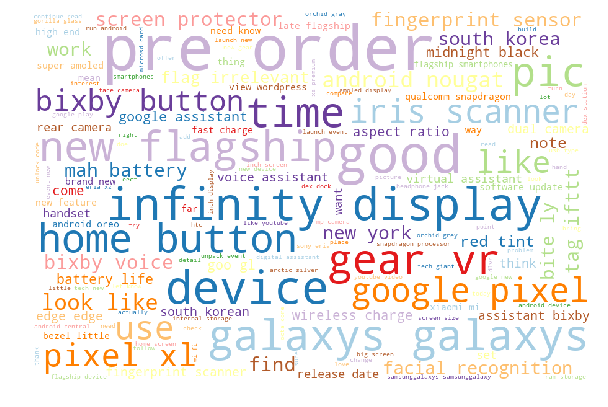

In [117]:
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=galaxy_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(galaxy)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("galaxy_word1.png", dpi=1000)


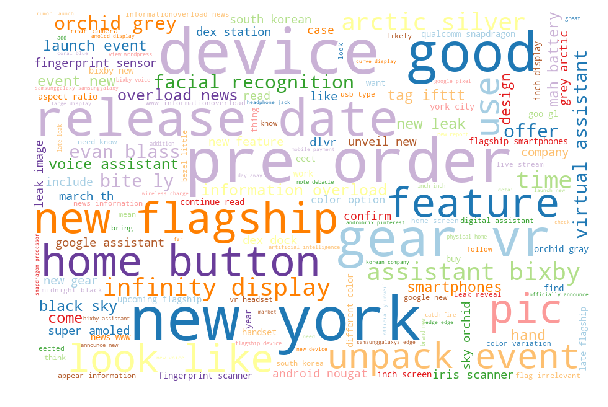

In [118]:
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=galaxy_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(galaxy_before)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("galaxy_before_word1.png", dpi=1000)


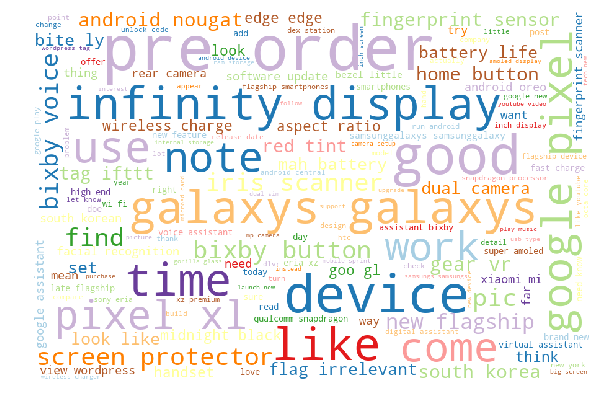

In [119]:
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=galaxy_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(galaxy_after)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("galaxy_after_word1.png", dpi=1000)


## Top n words

In [120]:
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']
both = nlp_data.loc[nlp_data['product'] == 'both']

In [122]:
from collections import Counter
iphone_histogram = Counter()
for row in iphone['clean']:
    for word in row:
        if word not in iphone_stopwords:
            iphone_histogram[word] += 1

In [123]:
iphone_sorted_lemma_count_pairs = sorted(iphone_histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

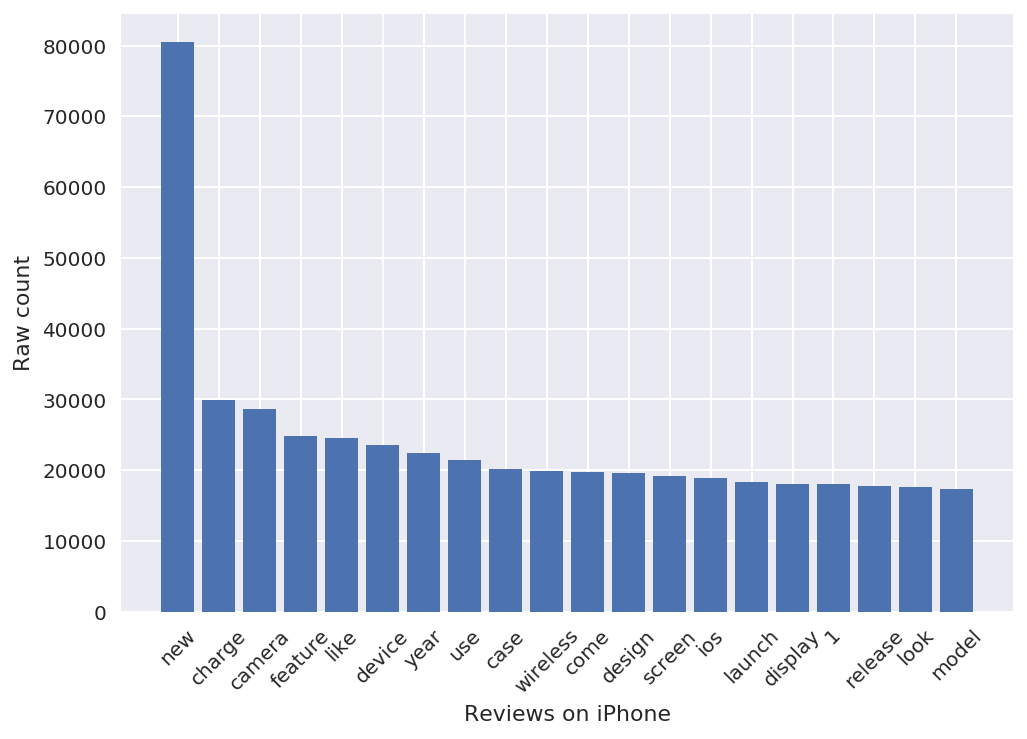

In [124]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Reviews on iPhone')
plt.ylabel('Raw count')

In [125]:
galaxy_histogram = Counter()
for row in galaxy['clean']:
    for word in row:
        if word not in iphone_stopwords:
            galaxy_histogram[word] += 1

In [126]:
galaxy_sorted_lemma_count_pairs = sorted(galaxy_histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

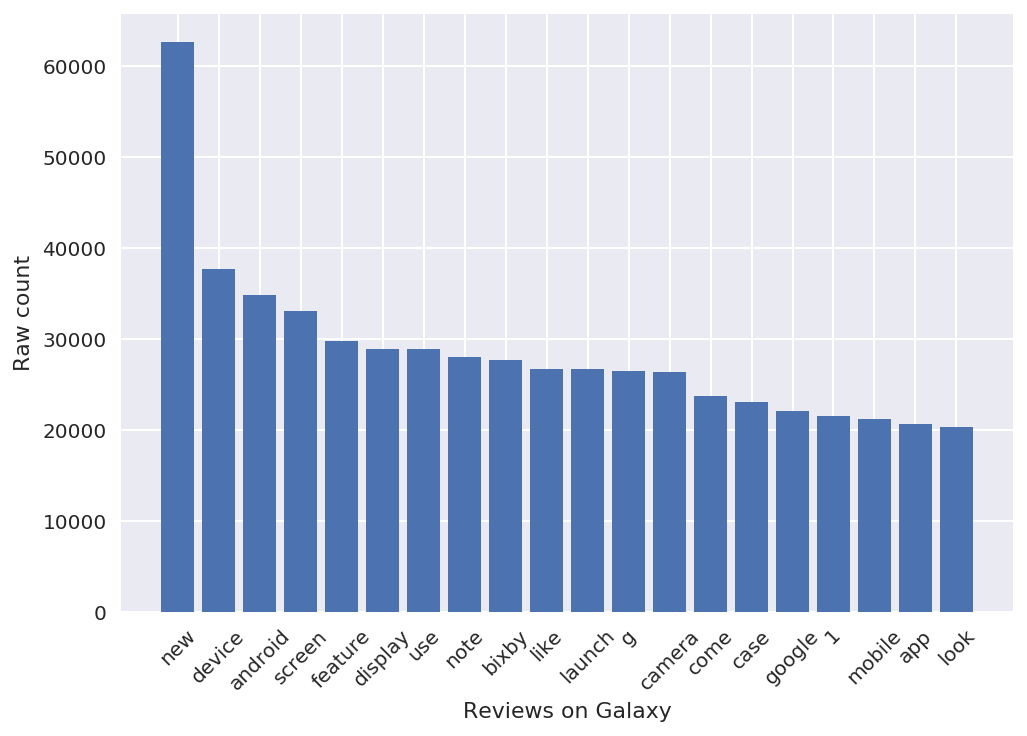

In [127]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Reviews on Galaxy')
plt.ylabel('Raw count')

In [128]:
both_histogram = Counter()
for row in both['clean']:
    for word in row:
        if word not in iphone_stopwords:
            both_histogram[word] += 1

In [129]:
both_sorted_lemma_count_pairs = sorted(both_histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

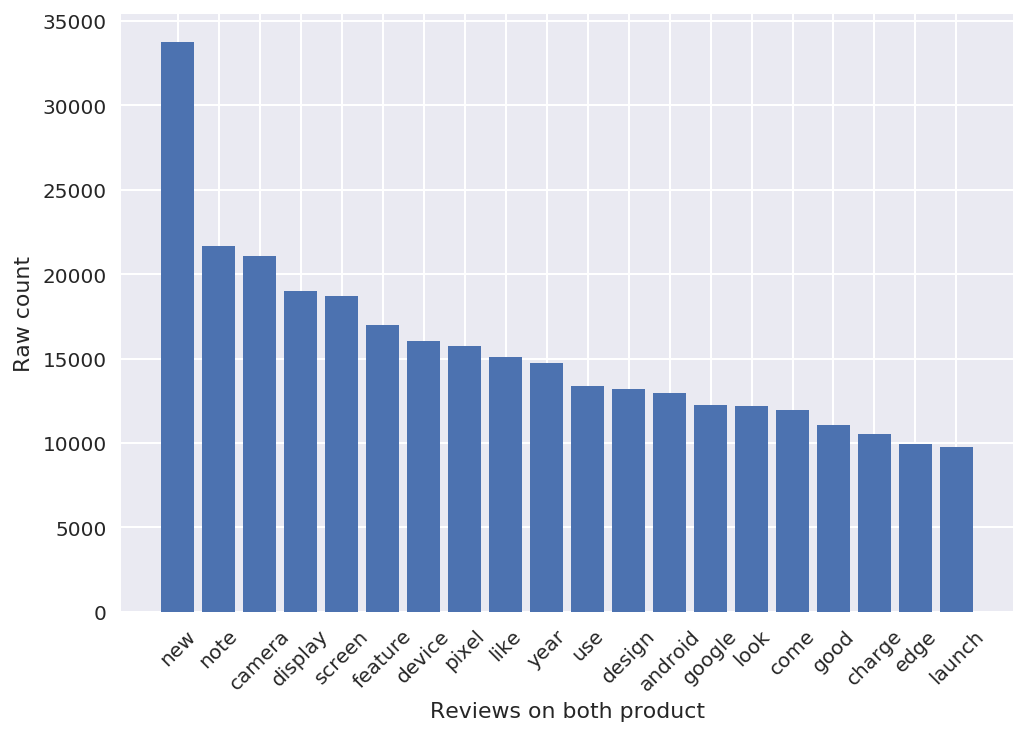

In [130]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in both_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in both_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Reviews on both product')
plt.ylabel('Raw count')

## Topic modeling using lemma

In [131]:
vocab_size = 10000
# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer_lemma = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=iphone_stopwords)
tf_vectorizer_gal_lemma = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=galaxy_stopwords)
tf_vectorizer_both_lemma = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=galaxy_stopwords)

In [184]:
iphone_lemma_after = nlp_data.loc[(nlp_data['product'] == 'iPhone')&(nlp_data['release']=='after')]['clean']
iphone_lemma_before = nlp_data.loc[(nlp_data['product'] == 'iPhone')&(nlp_data['release']=='before')]['clean']

In [185]:
galaxy_lemma_after = nlp_data.loc[(nlp_data['product'] == 'Galaxy')&(nlp_data['release']=='after')]['clean']
galaxy_lemma_before = nlp_data.loc[(nlp_data['product'] == 'Galaxy')&(nlp_data['release']=='before')]['clean']

In [186]:
both_lemma_after = nlp_data.loc[(nlp_data['product'] == 'both')&(nlp_data['release']=='after')]['clean']
both_lemma_before = nlp_data.loc[(nlp_data['product'] == 'both')&(nlp_data['release']=='before')]['clean']

In [187]:
iphone_text_lemma_after = [' '.join(i) for i in iphone_lemma_after]
iphone_text_lemma_before = [' '.join(i) for i in iphone_lemma_before]

In [188]:
galaxy_text_lemma_after = [' '.join(i) for i in galaxy_lemma_after]
galaxy_text_lemma_before = [' '.join(i) for i in galaxy_lemma_before]

In [189]:
both_text_lemma_after = [' '.join(i) for i in both_lemma_after]
both_text_lemma_before = [' '.join(i) for i in both_lemma_before]

In [190]:
tf_iphone_lemma_after = tf_vectorizer_lemma.fit_transform(iphone_text_lemma_after)
tf_iphone_lemma_before = tf_vectorizer_lemma.fit_transform(iphone_text_lemma_before)

In [191]:
tf_galaxy_lemma_after = tf_vectorizer_gal_lemma.fit_transform(galaxy_text_lemma_after)
tf_galaxy_lemma_before = tf_vectorizer_gal_lemma.fit_transform(galaxy_text_lemma_before)

In [192]:
tf_both_lemma_after = tf_vectorizer_both_lemma.fit_transform(both_text_lemma_after)
tf_both_lemma_before = tf_vectorizer_both_lemma.fit_transform(both_text_lemma_before)

## Using grid search to pick best lda model

In [240]:
# Define Search Param
search_params = {'n_components': [2,3,4,5,6,7]}
# Init the Model
lda_iphone_lemma = LatentDirichletAllocation(max_iter=5, learning_method='online',random_state=0)
# Init Grid Search Class
model_iphone_lemma = GridSearchCV(lda_iphone_lemma, param_grid=search_params)
# Do the Grid Search
model_iphone_lemma.fit(tf_iphone_lemma_after)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [2,3,4,5,6,7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [242]:
best_lda_model_iphone = model_iphone_lemma.best_estimator_
print("Best Model's Params: ", model_iphone_lemma.best_params_)
print("Best Log Likelihood Score: ", model_iphone_lemma.best_score_)
print("Model Perplexity: ", best_lda_model_iphone.perplexity(tf_iphone_lemma_after))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -4533682.513821604
Model Perplexity:  1585.5393995614518


In [88]:
best_lda_model_iphone

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=7, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [162]:
from sklearn.externals import joblib 
joblib.dump(best_lda_model_iphone,'best_lda_iphone.pkl')

['best_lda_iphone.pkl']

In [236]:
# Init the Model
lda_galaxy_lemma = LatentDirichletAllocation(max_iter=5, learning_method='online',random_state=0)
# Init Grid Search Class
model_galaxy_lemma = GridSearchCV(lda_galaxy_lemma, param_grid=search_params)
# Do the Grid Search
model_galaxy_lemma.fit(tf_galaxy_lemma_after)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [5,6,7,8,9,10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [237]:
best_lda_model_galaxy = model_galaxy_lemma.best_estimator_
print("Best Model's Params: ", model_galaxy_lemma.best_params_)
print("Best Log Likelihood Score: ", model_galaxy_lemma.best_score_)
print("Model Perplexity: ", best_lda_model_galaxy.perplexity(tf_galaxy_lemma_after))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -9694572.120613959
Model Perplexity:  1493.1148916510667


In [238]:
joblib.dump(best_lda_model_galaxy,'best_lda_galaxy.pkl')

['best_lda_galaxy.pkl']

In [227]:
search_params = {'n_components': [5,6,7,8,9,10]}
# Init the Model
lda_both_lemma = LatentDirichletAllocation(max_iter=5, learning_method='online',random_state=0)
# Init Grid Search Class
model_both_lemma = GridSearchCV(lda_both_lemma, param_grid=search_params)
# Do the Grid Search
model_both_lemma.fit(tf_both_lemma_after)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [5,6,7,8,9,10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [230]:
best_lda_model_both = model_both_lemma.best_estimator_
print("Best Model's Params: ", model_both_lemma.best_params_)
print("Best Log Likelihood Score: ", model_both_lemma.best_score_)
print("Model Perplexity: ", best_lda_model_both.perplexity(tf_both_lemma_after))

Best Model's Params:  {'n_components': 5}
Best Log Likelihood Score:  -4760598.454354664
Model Perplexity:  1433.720136515718


In [234]:
joblib.dump(best_lda_model_both,'best_lda_both.pkl')

['best_lda_both.pkl']

### Dominant topic for each post

In [4]:
#load best model
from sklearn.externals import joblib 
best_lda_model_iphone = joblib.load('best_lda_iphone.pkl')
best_lda_model_galaxy = joblib.load('best_lda_galaxy.pkl')
best_lda_model_both = joblib.load('best_lda_both.pkl')

In [250]:
# Dominant topics 
lda_output_iphone = best_lda_model_iphone.transform(tf_iphone_lemma_after)
lda_output_galaxy = best_lda_model_galaxy.transform(tf_galaxy_lemma_after)
lda_output_both = best_lda_model_galaxy.transform(tf_both_lemma_after)

In [245]:
topicnames_iphone = ['Topic' + str(i) for i in range(best_lda_model_iphone.n_components)]
postnames_iphone = [str(i) for i in range(len(iphone_lemma_after))]

In [246]:
topicnames_gal = ['Topic' + str(i) for i in range(best_lda_model_galaxy.n_components)]
postnames_gal = [str(i) for i in range(len(galaxy_lemma_after))]

In [247]:
topicnames_both = ['Topic' + str(i) for i in range(best_lda_model_both.n_components)]
postnames_both = [str(i) for i in range(len(both_lemma_after))]

In [248]:
# Make the pandas dataframe
df_post_topic_iphone_lemma_after = pd.DataFrame(np.round(lda_output_iphone, 2), columns=topicnames_iphone, index=postnames_iphone)

In [251]:
df_post_topic_galaxy_lemma_after = pd.DataFrame(np.round(lda_output_galaxy, 2), columns=topicnames_gal, index=postnames_gal)

In [252]:
df_post_topic_both_lemma_after = pd.DataFrame(np.round(lda_output_both, 2), columns=topicnames_both, index=postnames_both)

In [253]:
dominant_topic_iphone_lemma = np.argmax(df_post_topic_iphone_lemma_after.values, axis=1)
df_post_topic_iphone_lemma_after['dominant_topic'] = dominant_topic_iphone_lemma

In [254]:
dominant_topic_galaxy_lemma = np.argmax(df_post_topic_galaxy_lemma_after.values, axis=1)
df_post_topic_galaxy_lemma_after['dominant_topic'] = dominant_topic_galaxy_lemma

In [257]:
dominant_topic_both_lemma = np.argmax(df_post_topic_both_lemma_after.values, axis=1)
df_post_topic_both_lemma_after['dominant_topic'] = dominant_topic_both_lemma

In [258]:
# Styling
def color_green(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_post_topic_iphone_lemma_style = df_post_topic_iphone_lemma_after.head(10).style.applymap(color_green).applymap(make_bold)
df_post_topic_iphone_lemma_style

In [259]:
df_post_topic_iphone_lemma_after.groupby('dominant_topic').count()

Topic0  Topic1  Topic2  Topic3  Topic4
dominant_topic                                        
0                16651   16651   16651   16651   16651
1                 9980    9980    9980    9980    9980
2                10579   10579   10579   10579   10579
3                 8393    8393    8393    8393    8393
4                10291   10291   10291   10291   10291

In [260]:
df_post_topic_galaxy_lemma_style = df_post_topic_galaxy_lemma_after.head(15).style.applymap(color_green).applymap(make_bold)
df_post_topic_galaxy_lemma_style

In [261]:
df_post_topic_galaxy_lemma_after.groupby('dominant_topic').count()

Topic0  Topic1  Topic2  Topic3  Topic4
dominant_topic                                        
0                32797   32797   32797   32797   32797
1                27825   27825   27825   27825   27825
2                16843   16843   16843   16843   16843
3                10279   10279   10279   10279   10279
4                15516   15516   15516   15516   15516

In [262]:
df_post_topic_both_lemma_style = df_post_topic_both_lemma_after.head(15).style.applymap(color_green).applymap(make_bold)
df_post_topic_both_lemma_style

In [263]:
df_post_topic_both_lemma_after.groupby('dominant_topic').count()

Topic0  Topic1  Topic2  Topic3  Topic4
dominant_topic                                        
0                 4292    4292    4292    4292    4292
1                 6068    6068    6068    6068    6068
2                 6905    6905    6905    6905    6905
3                 1849    1849    1849    1849    1849
4                 4158    4158    4158    4158    4158

In [310]:
def topic_sample_post(topic_num, topic_matrix_df, raw_text_df):
    topic_df = topic_matrix_df.loc[topic_matrix_df['dominant_topic'] == topic_num]
    topic = 'Topic'+str(topic_num)
    index = topic_df.nlargest(15, topic).index.tolist()
    sample_post = [raw_text_df[int(i)] for i in index]
    return sample_post

In [311]:
iphone_sample_post_dict = {}
for i in range(5):
    post = topic_sample_post(i, df_post_topic_iphone_lemma_after,iphone_after_orignal)
    iphone_sample_post_dict[i] = post

In [312]:
for key,value in iphone_sample_post_dict.items():
    print('Topic:' + str(key))
    for i, post in enumerate(value):
        print("   Post " + str(i) + ' : '+ str(post))
    print(' ')

Topic:0
   Post 0 : DxOMark gives Pixel 2's camera a record score of 98, four points above iPhone 8 Plus and Note8; Pixel 2's 12MP sensor has f/1.8 aperture, Dual-Pixel Autofocus (DxOMark) DxOMark gives Pixel 2’s camera a record score of 98, four points above iPhone 8 Plus and Note8; Pixel 2’s 12MP sensor has f/1.8 aperture, Dual-Pixel Autofocus (DxOMark) ... DxOMark:
DxOMark gives Pixel 2’s camera a record score of 98, four points above iPhone 8 Plus and Note8; Pixel 2’s 12MP sensor has f/1.8 aperture, Dual-Pixel Autofocus — The Google Pixel 2 is the top-performing mobile device… View On WordPress Tags: #Dual-Pixel Autofocus (DxOMark) #DxOMark gives Pixel 2&039;s camera a record score of 98 #four points above iPhone 8 Plus and Note8; Pixel 2&039;s 12MP sensor has f/1.8 aperture
   Post 1 : DxOMark gives Pixel 2's camera a record score of 98, four points above iPhone 8 Plus and Note8; Pixel 2's 12MP sensor has f/1.8 aperture, Dual-Pixel Autofocus (DxOMark) DxOMark gives Pixel 2’s camer

In [313]:
galaxy_sample_post_dict = {}
for i in range(5):
    post = topic_sample_post(i, df_post_topic_galaxy_lemma_after,galaxy_after_orignal)
    galaxy_sample_post_dict[i] = post

In [314]:
for key,value in galaxy_sample_post_dict.items():
    print('Topic:' + str(key))
    for i, post in enumerate(value):
        print("   Post " + str(i) + ' : '+ str(post))
    print(' ')

Topic:0
   Post 0 : All your Android Reviews in one place Posted on by androidauthority It looks like Galaxy S8 Active might be coming to T-Mobile The Samsung Galaxy S Active series has always been exclusive to AT&T in the US. According to a report from VentureBeat , this could soon change, as the Galaxy S8 Active is expected make its way to T-Mobile as well. Evan Blass over at VentureBeat got his hands on marketing materials revealing that T-Mobile’s variant of the S8 Active will carry the model number SM-G892T. This isn’t surprising based on the fact that AT&T version of the device, which is already available and retails for $850, has the same model number but with an “A” at the end — SM-G892A. The device is said to be available in the same Meteor Gray and Titanium Gold color options, but there’s no word on when exactly it will be available or how much it will set you back. See also: Samsung Galaxy S8 Active: Why? Why does the Samsung Galaxy S8 Active exist? Don’t get me wrong, there

In [315]:
both_sample_post_dict = {}
for i in range(5):
    post = topic_sample_post(i, df_post_topic_both_lemma_after,both_after_orignal)
    both_sample_post_dict[i] = post

In [316]:
for key,value in both_sample_post_dict.items():
    print('Topic:' + str(key))
    for i, post in enumerate(value):
        print("   Post " + str(i) + ' : '+ str(post))
    print(' ')

Topic:0
   Post 0 : Samsung Galaxy S8 is getting an incredible camera feature that makes iPhone 8 Plus loving Samsung Galaxy S8 is getting an incredible camera feature that makes iPhone 8 Plus loving October 18, 2017 •
   Post 1 : Shanghaichica said: ↑ Aren’t they both 18:9? Click to expand... Galaxy S8 is 18.5:9. iPhone X is 19.5:9.
   Post 2 : Not working...even after reinstalling...working fine in iPhone but not in Galaxy s8
   Post 3 : The iPhone 8 SHOULD be able to beat the Galaxy S8 in ALL areas.
   Post 4 : How to Unlock Samsung Galaxy S8 PLUS for AT&T Wireless https://t.co/Jipnx5SIIP #UNLOCKFUSION #IPHONE https://t.co/lTpwrZoli3 UnlockFusion.com via Twitter https://twitter.com/UnlockFusion https://t.co/lTpwrZoli3 Tags: #UnlockFusion #FusionUnlock #imeiunlock #freeunlock #freeunlocks #samsungcode #unlockphones #freeunlockcodes
   Post 5 : How to Unlock Samsung Galaxy S8 PLUS for AT&T Wireless https://t.co/Jipnx5SIIP #UNLOCKFUSION #IPHONE https://t.co/lTpwrZoli3 UnlockFusion.com 

## Topic word cloud

In [272]:
# word cloud for each topic
def topic_word_cloud(topic_num, topic_matrix_df, lemma_df):
    topic_df = topic_matrix_df.loc[topic_matrix_df['dominant_topic'] == topic_num]
    text = [lemma_df[int(i)] for i in topic_df.index.tolist()]
    text = [word for sentence in text for word in sentence.split(' ')]
    text = ' '.join(text)
    return text

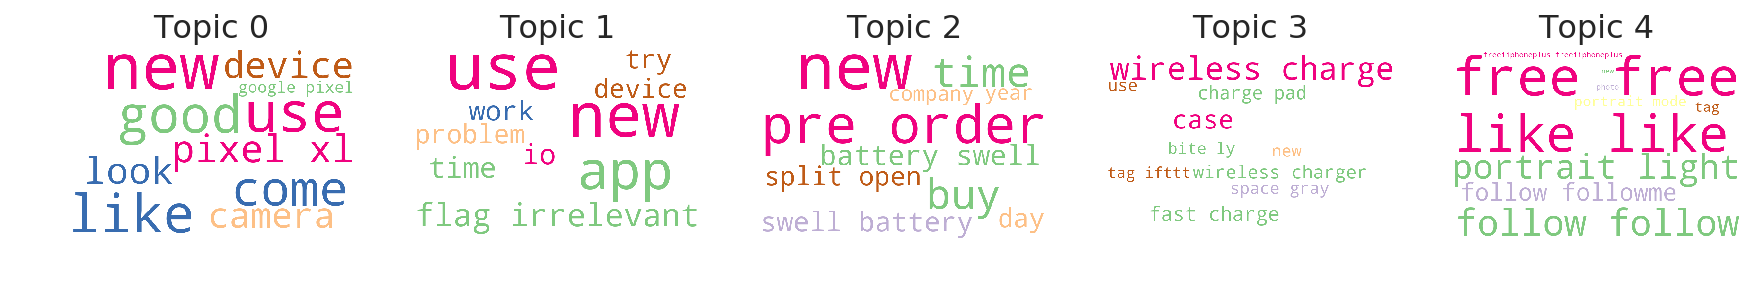

In [343]:
fig, axes = plt.subplots(1, 5, figsize=(15,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    text = topic_word_cloud(i,df_post_topic_iphone_lemma_after, iphone_text_lemma_after)   
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Accent',
                          max_words=10,
                          max_font_size=200,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(text)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
#     name = 'topic/iphone_after_topic' + str(i) + '.png'
#     plt.savefig(name, dpi=9000)

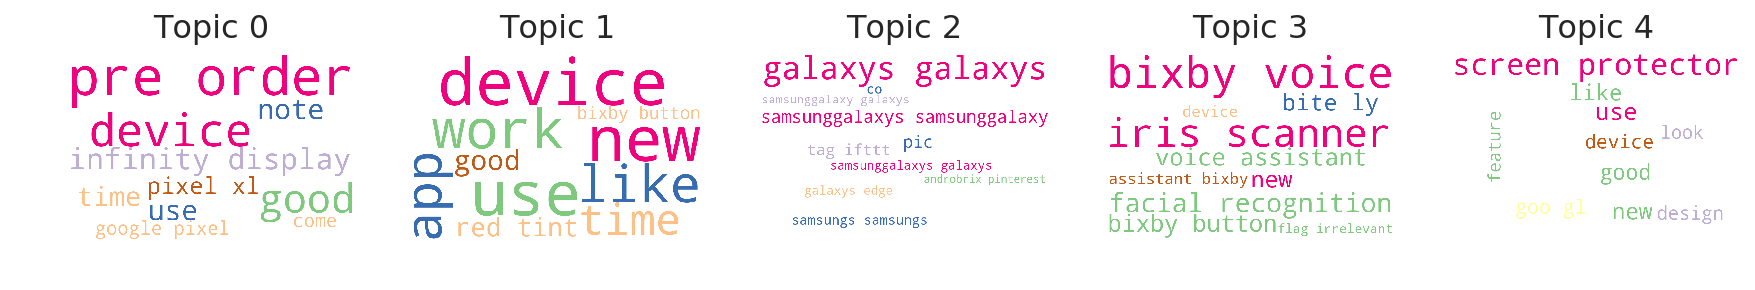

In [275]:
fig, axes = plt.subplots(1, 5, figsize=(15,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    text = topic_word_cloud(i,df_post_topic_galaxy_lemma_after, galaxy_text_lemma_after)   
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Accent',
                          max_words=10,
                          max_font_size=200,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(text)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    name = 'topic/galaxy_after_topic' + str(i) + '.png'
    fig.savefig(name, dpi=1000)
    plt.gca().axis('off')

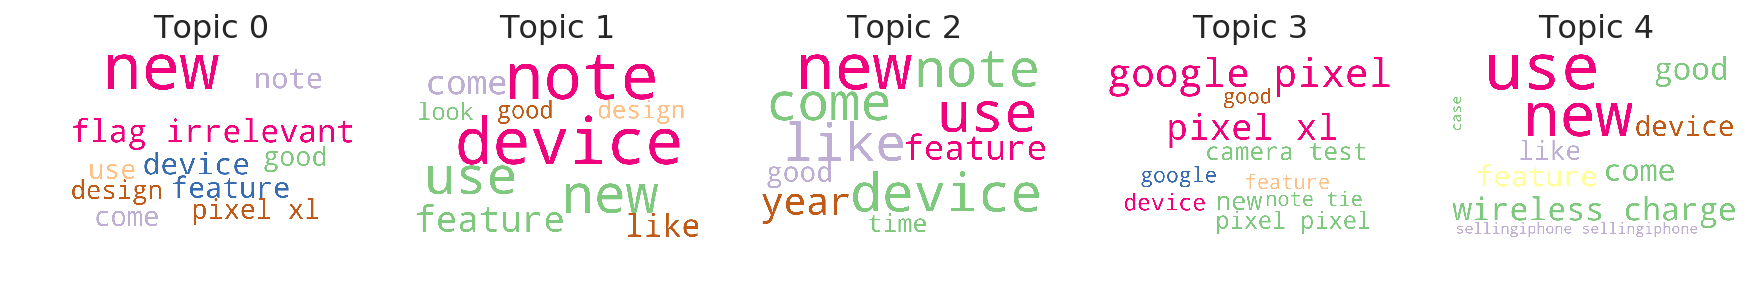

In [277]:
fig, axes = plt.subplots(1, 5, figsize=(15,20), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    text = topic_word_cloud(i,df_post_topic_both_lemma_after, both_text_lemma_after)   
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Accent',
                          max_words=10,
                          max_font_size=200,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(text)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    name = 'topic/both_after_topic' + str(i) + '.png'
    fig.savefig(name, dpi=1000)
    plt.gca().axis('off')

### Create keywords network graph

In [278]:
vocab_size = 25
# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer_lemma_net = CountVectorizer(max_df=0.9,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=iphone_stopwords)
tf_vectorizer_gal_lemma_net = CountVectorizer(max_df=0.9,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=galaxy_stopwords)

In [279]:
iphone_lemma_before = nlp_data.loc[(nlp_data['product'] == 'iPhone')&(nlp_data['release']=='before')]['clean']
iphone_lemma_after = nlp_data.loc[(nlp_data['product'] == 'iPhone')&(nlp_data['release']=='after')]['clean']

In [280]:
galaxy_lemma_before = nlp_data.loc[(nlp_data['product'] == 'Galaxy')&(nlp_data['release']=='before')]['clean']
galaxy_lemma_after = nlp_data.loc[(nlp_data['product'] == 'Galaxy')&(nlp_data['release']=='after')]['clean']

In [281]:
tf_iphone_lemma_net_before = tf_vectorizer_lemma_net.fit_transform(iphone_text_lemma_before)
tf_iphone_lemma_net_after = tf_vectorizer_lemma_net.fit_transform(iphone_text_lemma_after)

In [282]:
tf_galaxy_lemma_net_before = tf_vectorizer_gal_lemma_net.fit_transform(galaxy_text_lemma_before)
tf_galaxy_lemma_net_after = tf_vectorizer_gal_lemma_net.fit_transform(galaxy_text_lemma_after)

In [283]:
tf_iphonec_lemma_before = tf_iphone_lemma_net_before.T * tf_iphone_lemma_net_before
tf_iphonec_lemma_after = tf_iphone_lemma_net_after.T * tf_iphone_lemma_net_after

In [284]:
tf_iphonec_lemma_before.setdiag(0)
tf_iphonec_lemma_after.setdiag(0)

In [285]:
iphone_names_before = tf_vectorizer_lemma_net.get_feature_names()
ihpone_mapping_before = {i:iphone_names_before[i] for i in range(len(iphone_names_before))}
G_iphone_before=nx.from_scipy_sparse_matrix(tf_iphonec_lemma_before)
H_iphone_before = nx.relabel_nodes(G_iphone_before, ihpone_mapping_before)

In [286]:
iphone_names_after = tf_vectorizer_lemma_net.get_feature_names()
ihpone_mapping_after = {i:iphone_names_after[i] for i in range(len(iphone_names_after))}
G_iphone_after=nx.from_scipy_sparse_matrix(tf_iphonec_lemma_after)
H_iphone_after = nx.relabel_nodes(G_iphone_after, ihpone_mapping_after)

### iPhone

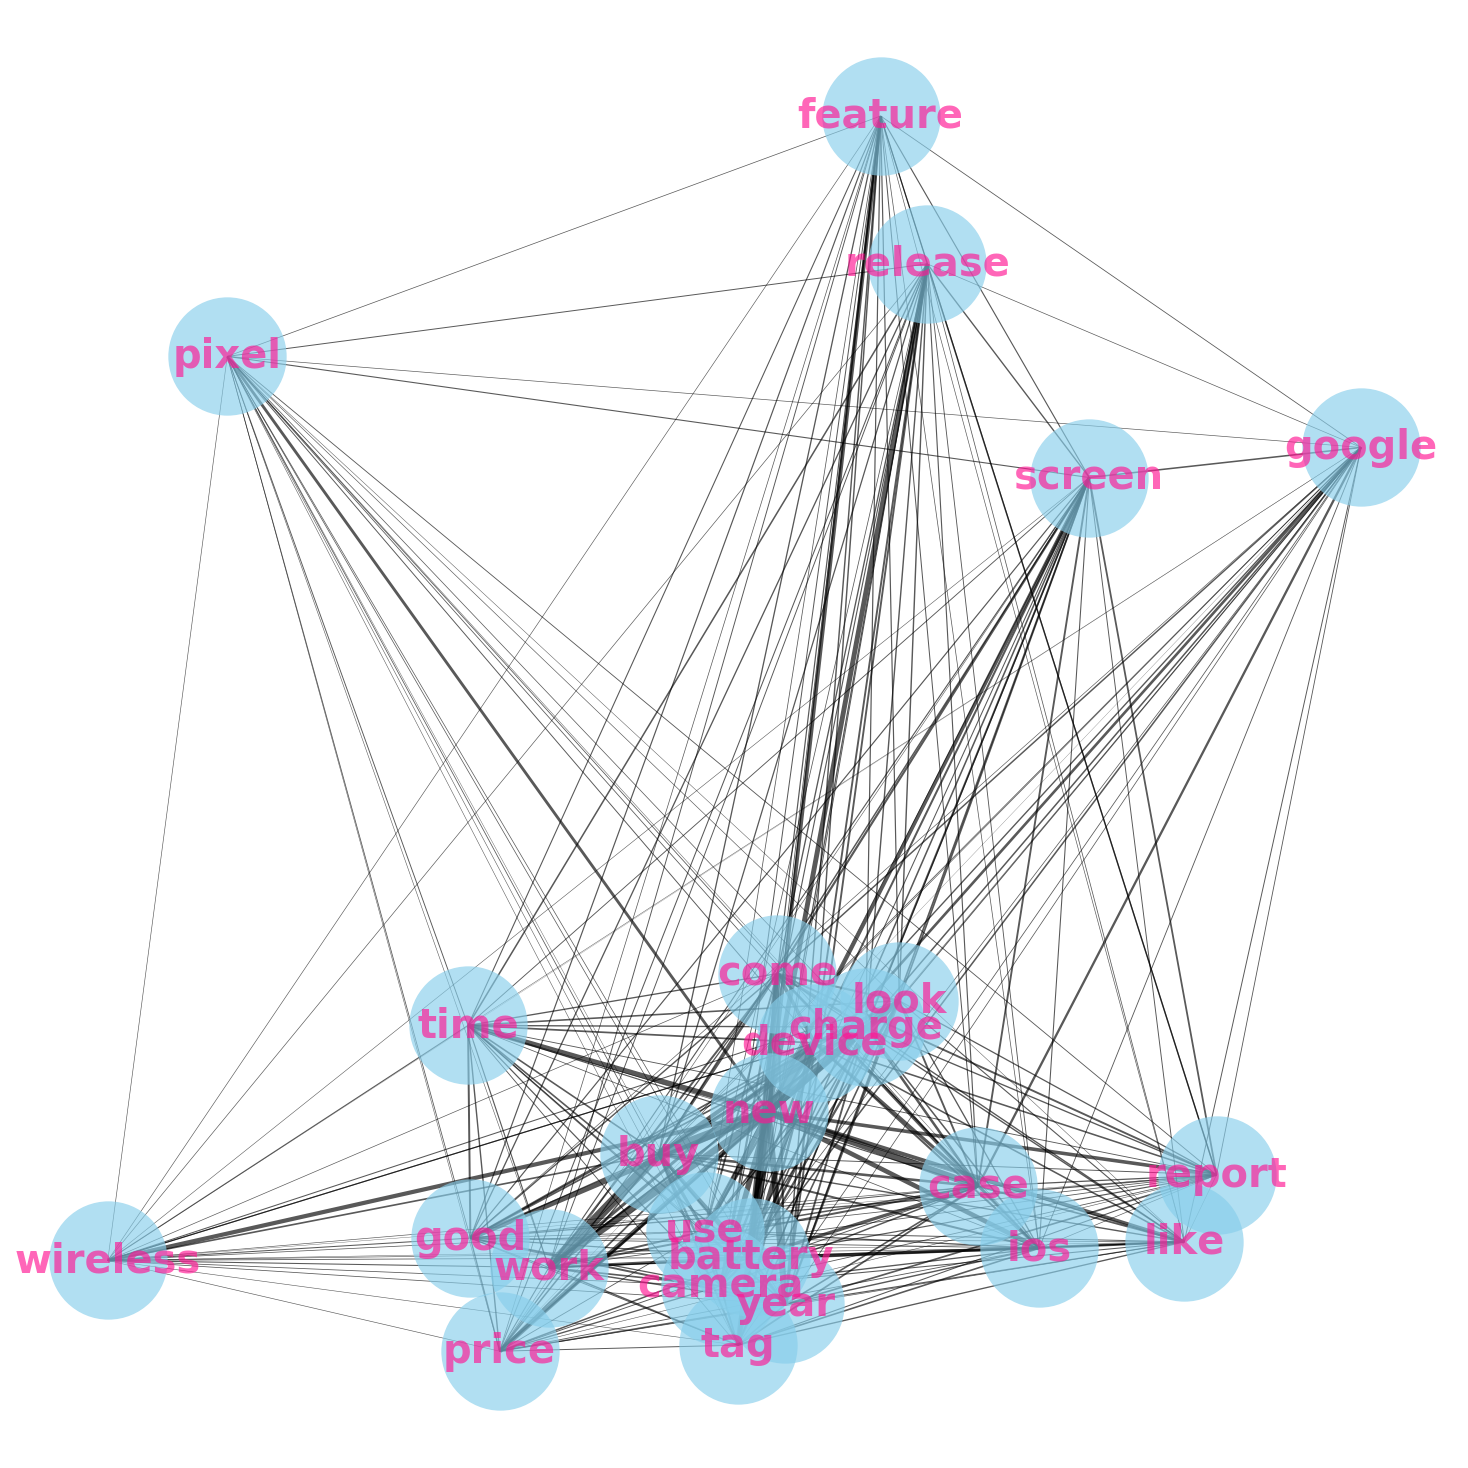

In [326]:
edges = H_iphone_before.edges()
weights = [H_iphone_before[u][v]['weight'] for u,v in edges]
weights = [i/10000 for i in weights]
plt.figure(figsize = (10,10))
options = {
    'node_color': "skyblue",
    'node_size': 3500,
    'alpha' : 0.65,
    'line_color': 'grey',
    'linewidths': 0,
    'font_weight':'bold',
    'font_color':'deeppink',
    'font_size':20
}
nx.draw(H_iphone_before, with_labels=True, **options,width = weights)
#plt.savefig('network_iphone_before.png', dpi = 900)

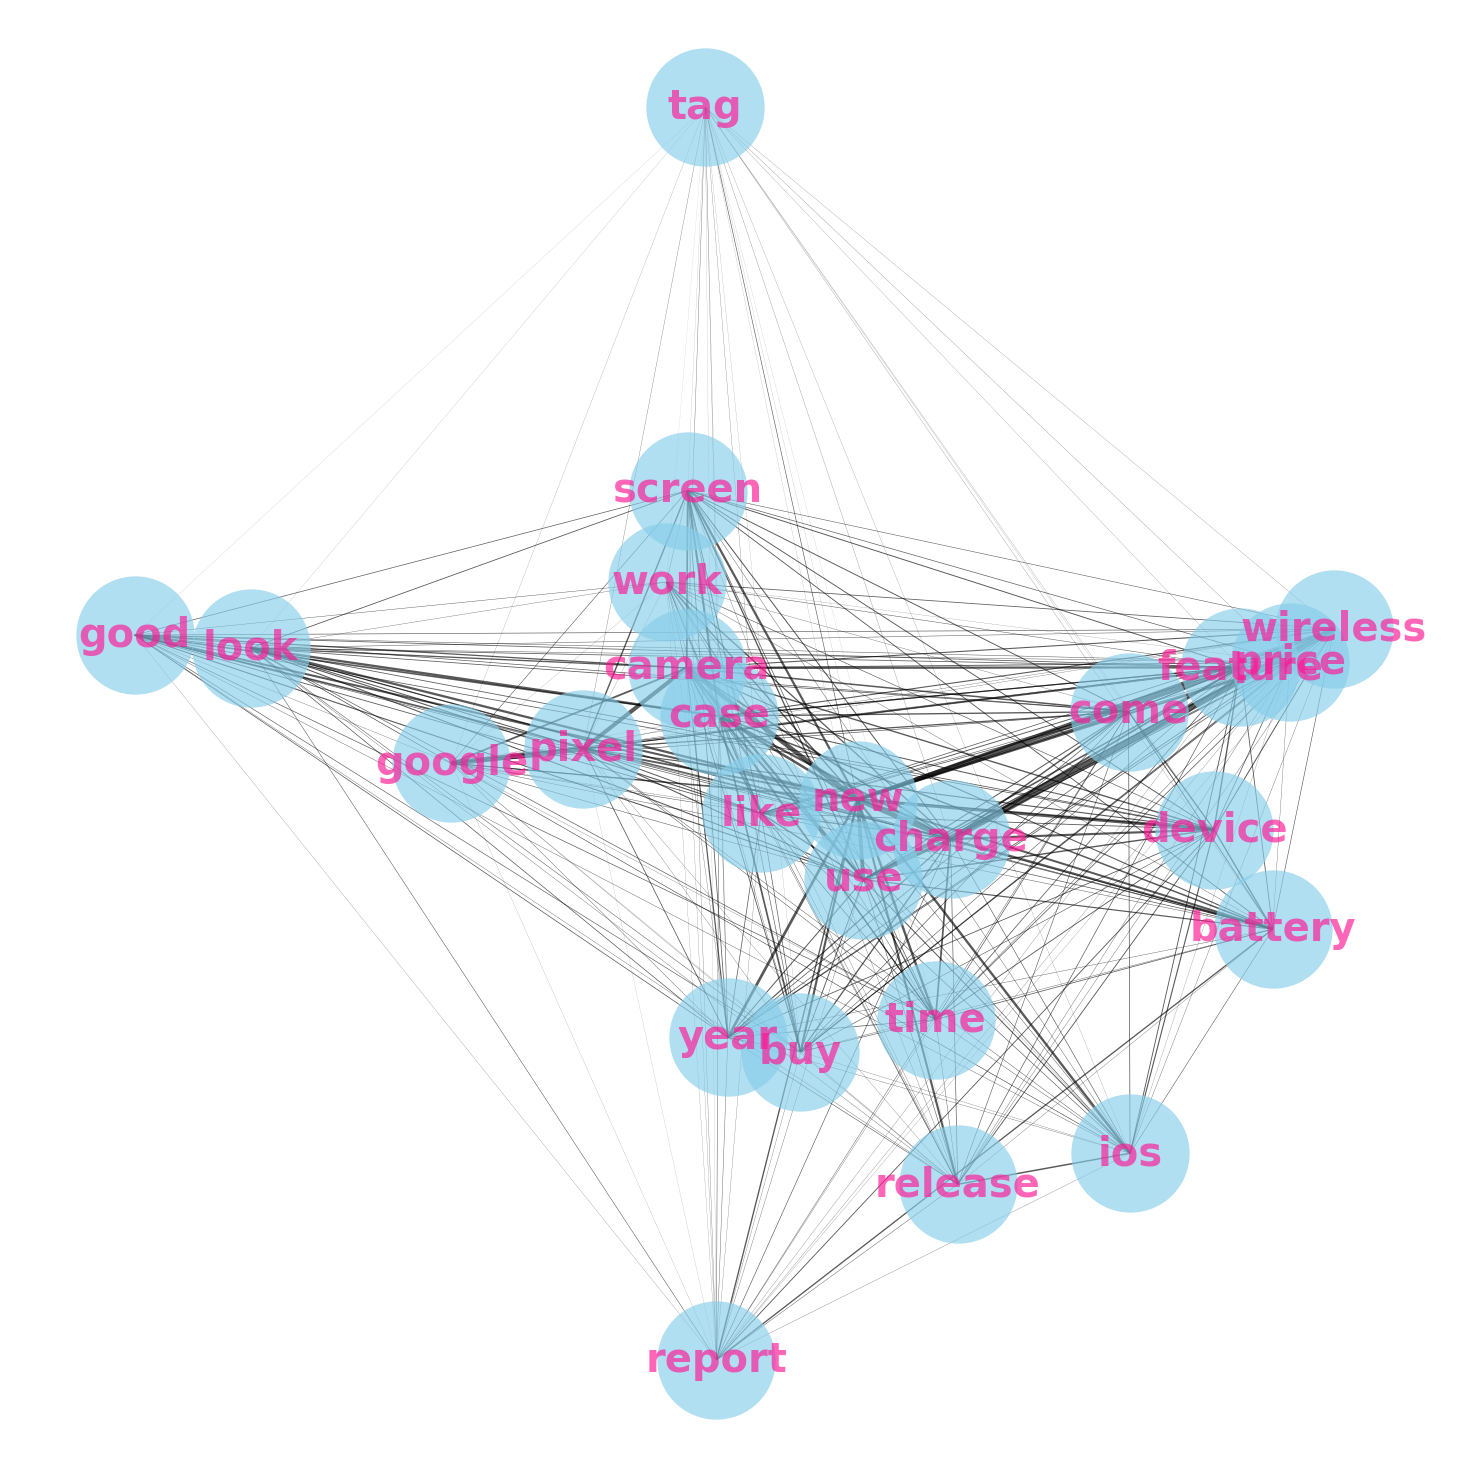

In [330]:
edges = H_iphone_after.edges()
weights = [H_iphone_after[u][v]['weight'] for u,v in edges]
weights = [i/10000 for i in weights]
plt.figure(figsize = (10,10))
options = {
    'node_color': "skyblue",
    'node_size': 3500,
    'alpha' : 0.65,
    'line_color': 'grey',
    'linewidths': 0,
    'font_weight':'bold',
    'font_color':'deeppink',
    'font_size':20
}
nx.draw(H_iphone_after, with_labels=True, **options,width = weights)
#plt.savefig('network_iphone_after.png', dpi = 900)

### Galaxy

In [289]:
tf_galaxyc_lemma_before = tf_galaxy_lemma_net_before.T * tf_galaxy_lemma_net_before
tf_galaxyc_lemma_after = tf_galaxy_lemma_net_after.T * tf_galaxy_lemma_net_after

In [290]:
tf_galaxyc_lemma_before.setdiag(0)
tf_galaxyc_lemma_after.setdiag(0)

In [291]:
galaxy_names_before = tf_vectorizer_gal_lemma_net.get_feature_names()
galaxy_mapping_before = {i:galaxy_names_before[i] for i in range(len(galaxy_names_before))}
G_galaxy_before=nx.from_scipy_sparse_matrix(tf_galaxyc_lemma_before)
H_galaxy_before = nx.relabel_nodes(G_galaxy_before, galaxy_mapping_before)

In [292]:
galaxy_names_after = tf_vectorizer_gal_lemma_net.get_feature_names()
galaxy_mapping_after = {i:galaxy_names_after[i] for i in range(len(galaxy_names_after))}
G_galaxy_after=nx.from_scipy_sparse_matrix(tf_galaxyc_lemma_after)
H_galaxy_after = nx.relabel_nodes(G_galaxy_after, galaxy_mapping_after)

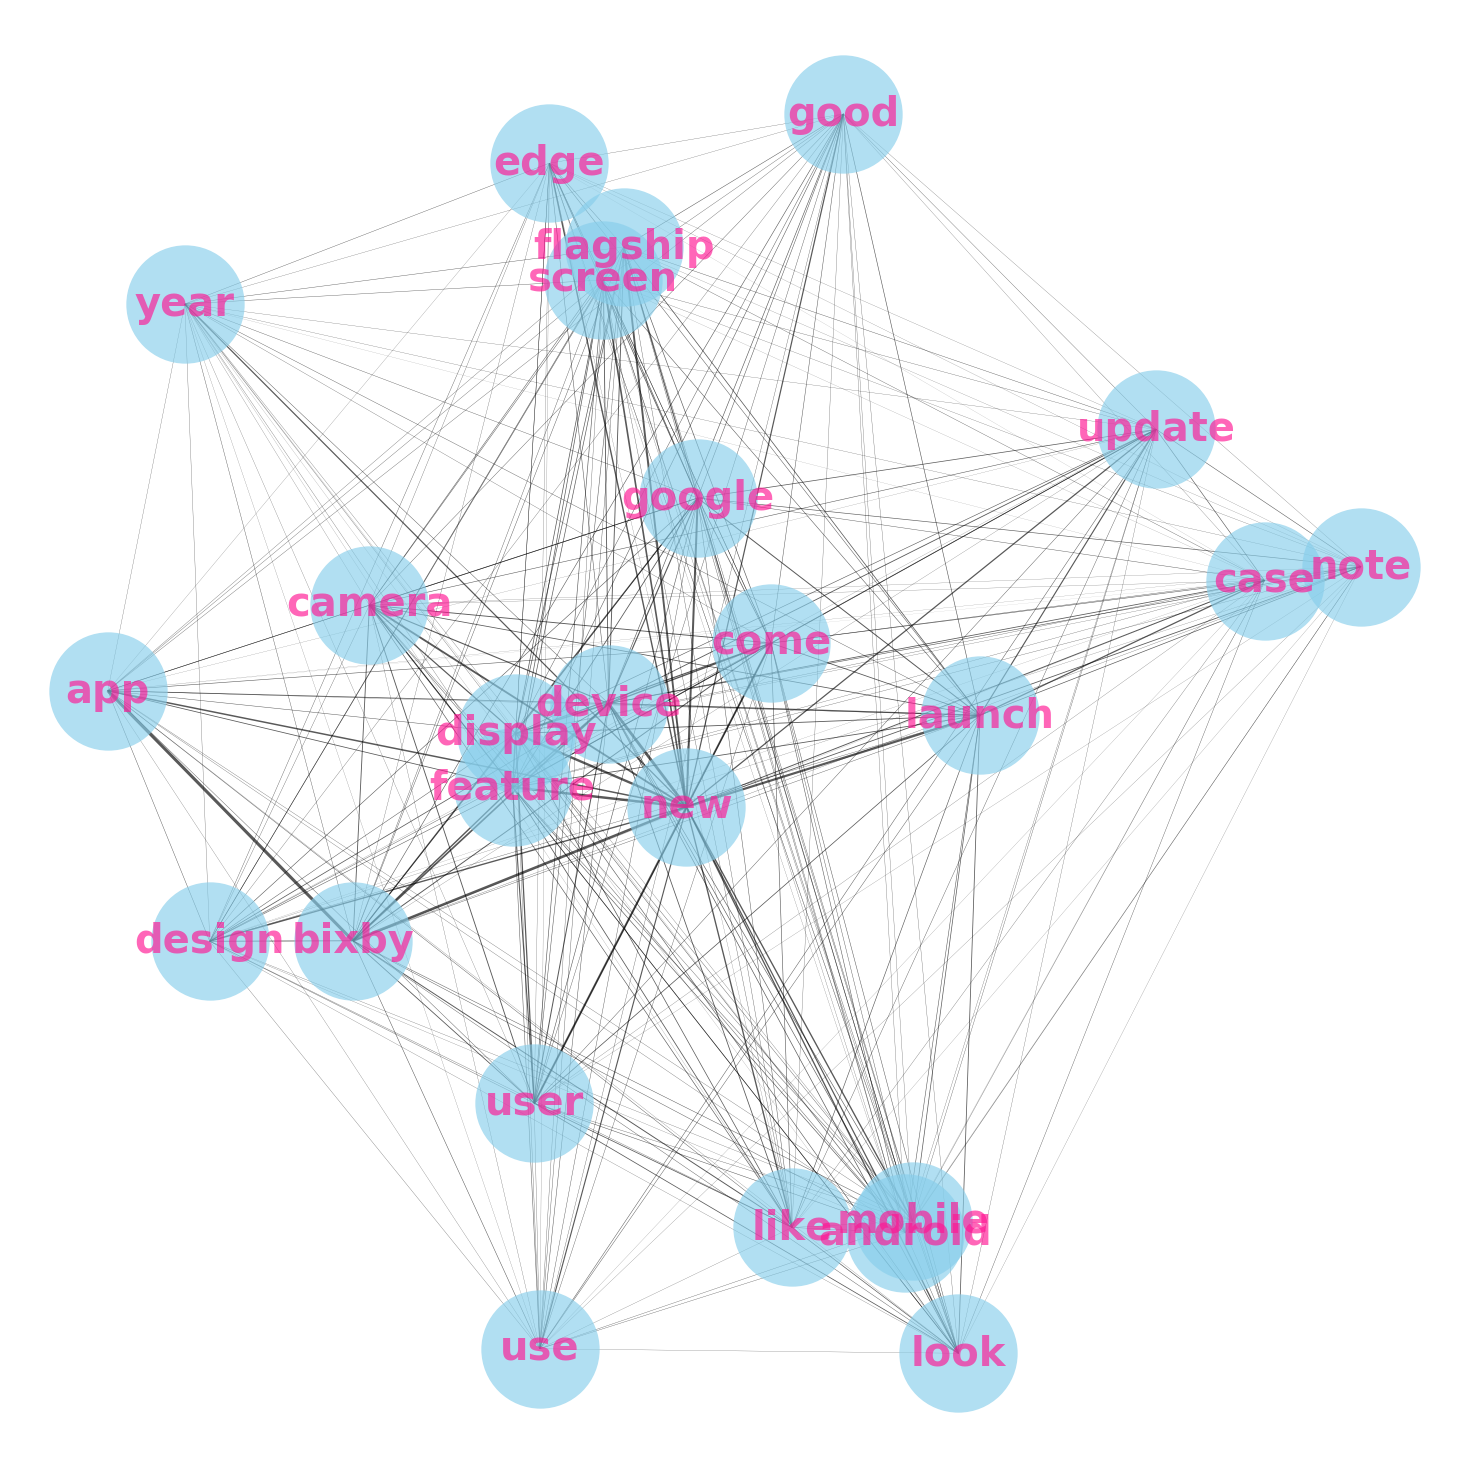

In [294]:
edges = H_galaxy_before.edges()
weights = [H_galaxy_before[u][v]['weight'] for u,v in edges]
weights = [i/10000 for i in weights]
plt.figure(figsize = (10,10))
options = {
    'node_color': "skyblue",
    'node_size': 3500,
    'alpha' : 0.65,
    'line_color': 'grey',
    'linewidths': 0,
    'font_weight':'bold',
    'font_color':'deeppink',
    'font_size':20
}
nx.draw(H_galaxy_before, with_labels=True, **options, width = weights)
#plt.savefig('network_galaxy_before.png', dpi = 900)

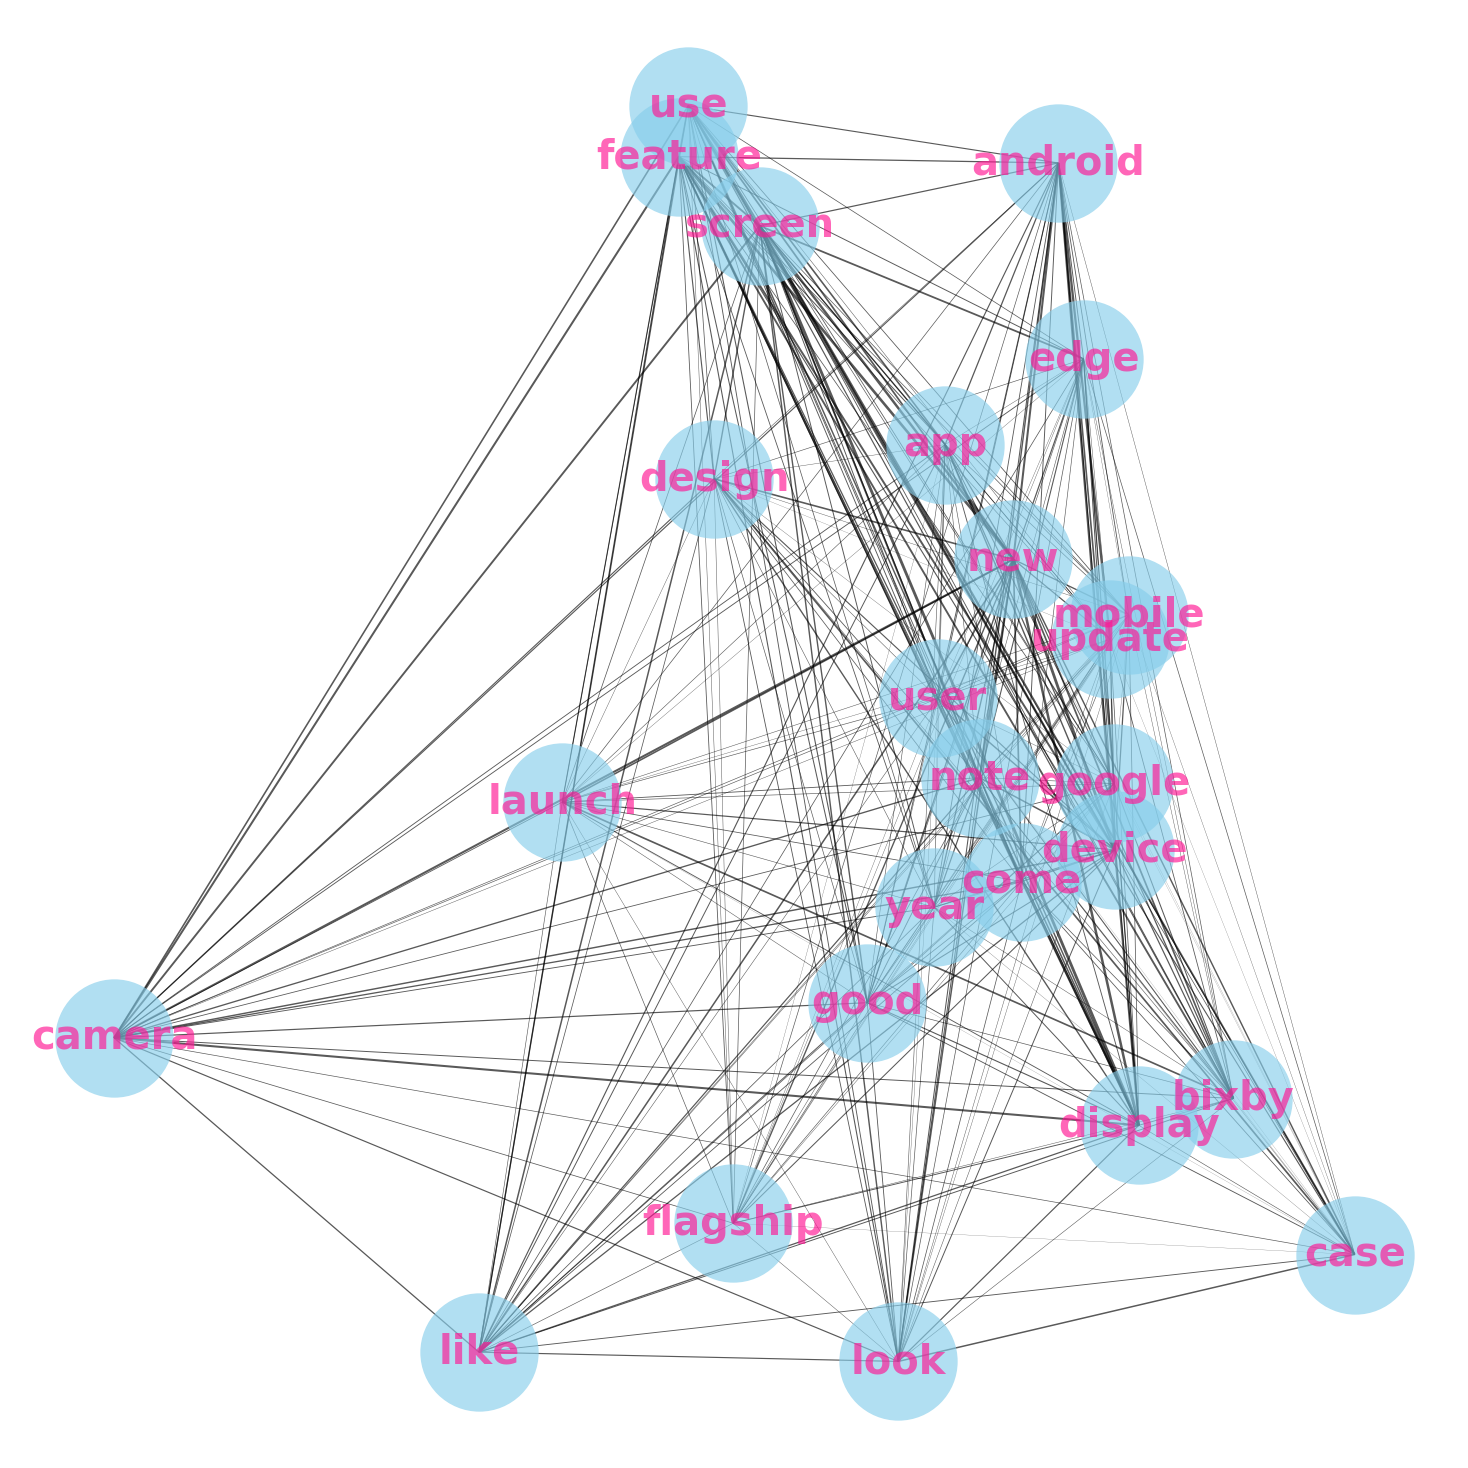

In [338]:
edges = H_galaxy_after.edges()
weights = [H_galaxy_after[u][v]['weight'] for u,v in edges]
weights = [i/30000 for i in weights]
plt.figure(figsize = (10,10))
options = {
    'node_color': "skyblue",
    'node_size': 3500,
    'alpha' : 0.65,
    'line_color': 'grey',
    'linewidths': 0,
    'font_weight':'bold',
    'font_color':'deeppink',
    'font_size':20
}
nx.draw(H_galaxy_after, with_labels=True, **options, width = weights)
#plt.savefig('network_galaxy_after.png', dpi = 900)